<font style='font-family: "Times New Roman", Times, serif;,color:#000099;font-weight:900;font-size:24px;text-decoration:underline;'>Curiosity project - Part C</font>

Amir Wolfensohn - 300339785, Or Sharir - 201314796, Adam Bartash - 206321440, Yishay Shapira - 203016217

1.  Imports
2.  Read the data
3.  Functions
4.  Pre processing
5.  Pre evaluation
6.  CFS - Curious feature selection
7.  Models comparison

<font style='font-weight:750;font-size:16px;text-decoration:underline;'>Imports</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import math
from random import sample, seed
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense , Dropout
import tensorflow.keras.backend as K
import seaborn as sns
from datetime import datetime

<font style='font-weight:750;font-size:16px;text-decoration:underline;'>Read the data</font>

In [2]:
path = r"understat_per_game.csv"
all_data = pd.read_csv(path)
all_data = all_data.sample(frac=1).reset_index(drop=True)

In [3]:
print(set(all_data))

{'ppda_def', 'ppda_coef', 'npxG', 'loses', 'scored', 'oppda_coef', 'oppda_def', 'xG', 'npxGA', 'team', 'date', 'h_a', 'league', 'missed', 'xpts', 'deep_allowed', 'xGA', 'deep', 'wins', 'year', 'xGA_diff', 'pts', 'npxGD', 'ppda_att', 'xpts_diff', 'result', 'draws', 'oppda_att', 'xG_diff'}


<font style='font-weight:750;font-size:16px;text-decoration:underline;'>Functions:</font>

In [4]:
# normalizing feature values from zero to one
def NormalizingFromZeroToOne(column_):
    Max= column_.max()
    Min= column_.min()
    MinMax= Max-Min
    res = (column_-Min)/(MinMax)
    return res

In [5]:
def df_to_arr(features_, target_):
    # convert the dataframes to np arrays 
    features_arr = features_.iloc[:,:].values
    target_arr= target_.iloc[:].values
    # convert the target to categorical 
    target_arr = keras.utils.to_categorical(target_arr, 3)
    return features_arr, target_arr  

In [6]:
# in order to run single model with set of hyper-parameters
def run_model(x_train_, x_train_arr_, y_train_arr_, x_val_arr_, y_val_arr_, num_units, num_units_list, dropout_list, active_func, optimizer_):
    #keras.backend.clear_session()
    model = Sequential()
    for l in range(num_units):
        #to prevent overfitting
        model.add(Dropout(dropout_list[l], input_shape=[x_train_.shape[1]]))
        model.add(Dense(num_units_list[l], activation=active_func ,input_shape=[x_train_.shape[1]],kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001,l2=0.001)))
        
    model.add(Dense(3, activation='softmax')) # 3  because we have 3 possible values in the target 
    
    #model.summary()
    
    model.compile(loss="categorical_crossentropy", optimizer=optimizer_, metrics=[tf.keras.metrics.CategoricalAccuracy()])
    history = model.fit(x=x_train_arr_, y=y_train_arr_, batch_size=32, epochs=60, validation_data=(x_val_arr_,y_val_arr_) , verbose=0)
    return model, history

In [7]:
# calculating mse error
def get_error(actual, predict):
    if len(actual) != len(predict): raise Exception("the actual and the predict arrays are not in the same size!")
    res = np.sum(pow(actual - predict, 2))/2
    return res

In [8]:
def print_q(q_matrix):
    rows    = len(q_matrix)
    columns = len(q_matrix[0])
    MyMin     = min([min(nnn) for nnn in q_matrix])
    for iii in range(0,rows,1):
        kkk   = 0
        mmm   = MyMin
        uuu   = 0
        for lll in range(0,columns,1):
            if( (mmm<=q_matrix[iii,lll]) and (q_matrix[iii,lll]!=1) and (iii!=lll) ):
                mmm= q_matrix[iii,lll]
                uuu= lll
        MyColorString= ""
        for jjj in range(0,columns,1):
            if(iii==jjj):
                MyColorString= MyColorString+'\033[33m'+"{:7.3f}".format(q_matrix[iii,jjj])+'\033[0m'
            else:
                if(jjj==uuu):
                    MyColorString= MyColorString+'\033[31m'+"{:7.3f}".format(q_matrix[iii,jjj])+'\033[0m'
                else:
                    MyColorString= MyColorString+'\033[37m'+"{:7.3f}".format(q_matrix[iii,jjj])+'\033[0m'
        print(MyColorString)

<font style='font-weight:750;font-size:16px;text-decoration:underline;'>Pre processing</font>

In [9]:
# creating a single target column: 
# lose=0, draw=1, win=2 
all_data['Target'] =np.where(all_data['loses']==1,0,
                np.where(all_data['draws']==1,1,
                np.where(all_data['wins']==1,2,3
                ))) 

In [10]:
# removing not relvant columns (useless features and target dependency columns)
all_data = all_data.drop(['league', 'year', 'result', 'scored', 'missed', 'xpts', 'date', 
           'wins', 'draws', 'loses', 'pts', 'team','h_a','xG_diff','xGA_diff','xpts_diff'], axis = 1) 

In [11]:
data = all_data.copy()

In [12]:
Target = data.pop('Target')
# normalize all the features to be from zer to one
for feat in data:
    data[feat] = NormalizingFromZeroToOne(data[feat])

<font style='font-weight:750;font-size:16px;text-decoration:underline;'>Pre evaluation</font>

In [13]:
# split the data to train(80%), and test(20%)
x_train, x_test, y_train, y_test = train_test_split(data, Target, test_size=0.20, random_state=55)
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [14]:
# convert the dataframes to np arrays 
x_train_arr, y_train_arr = df_to_arr(x_train, y_train)
x_test_arr, y_test_arr = df_to_arr(x_test, y_test)

<font style='font-weight:750;font-size:16px;text-decoration:underline;'>CFS - Curious feature selection</font>

In [15]:
# alpha is the learning rate
def get_alpha(index_, itr_):
    alpha_ = 0.09
    if index_ < itr_/4: alpha_ = 0.09
    elif itr_/4 <= index_ < itr_/2: alpha_ = 0.05
    elif itr_/2 <= index_ < itr_*0.75: alpha_ = 0.01
    else: alpha_ = 0.005
    return alpha_

In [16]:
# epsilon is the tuner between exploration and exploitation
def get_epsilon(index_, itr_):
    epsilon_ = 0.9
    if index_ < itr_/4: epsilon_ = 0.9
    elif itr_/4 <= index_ < itr_/2: epsilon_ = 0.5
    elif itr_/2 <= index_ < itr_*0.75: epsilon_ = 0.3
    else: epsilon_ = 0.1
    return epsilon_

In [17]:
# the parameters for the curiousity loop
F = x_train.shape[1]
# Q = [state, action]
Q = np.ones([F+1, F+1])
N_data = x_train.shape[0]
N_epi = 100
itr = int(10 * N_data / N_epi)
gamma = 0.9
threshold = -0.1

error_list=[]
reward_list=[]
val_loss_list=[]
accuracy_list=[]

In [18]:
# the curiousity loop 
for i in range(itr):
    keras.backend.clear_session()
    print('i: ',i)
    X_epi = x_train.sample(n=N_epi)
    Y_epi = y_train[X_epi.index]
    X_epi_train, X_epi_val, Y_epi_train, Y_epi_val = train_test_split(X_epi, Y_epi, test_size=0.20)
    
    X_epi_train = X_epi_train.reset_index(drop=True)
    Y_epi_train = Y_epi_train.reset_index(drop=True)
    X_epi_val = X_epi_val.reset_index(drop=True)
    Y_epi_val = Y_epi_val.reset_index(drop=True)
    
    X_epi_train_temp=X_epi_train
    Y_epi_train_temp=Y_epi_train
    X_epi_val_temp=X_epi_val
    Y_epi_val_temp=Y_epi_val
    
    previous_error = 0.5
    state = 0
    action = None 
    F = set()
    available_F = set(range(1,X_epi_train.shape[1]+1))
    epsilon = get_epsilon(i, itr)
    alpha = get_alpha(i, itr)
    
    reward = []
    error = []
    val_loss = []
    accuracy = []
    while len(available_F) > 0:
        if np.random.uniform(0, 1) < epsilon:
            action = sample(available_F,1)[0]
        else:
            highest_value = np.max(Q[state,list(available_F)])
            if highest_value < threshold and len(F) >0:
                print('early stopping, the value is: ',highest_value)
                break
            action = np.intersect1d(np.argwhere(Q[state,:]==highest_value),list(available_F))[0]
            
        available_F.remove(action)
        F.add(action)
        
        # choose only the F features to be in the train and val data sets
        # we need the F_minus_one because the real features are strating from zero and not form one
        F_minus_one = [feat - 1 for feat in F]
        X_epi_train_temp = X_epi_train.iloc[:,list(F_minus_one)]
        X_epi_val_temp = X_epi_val.iloc[:,list(F_minus_one)]
        
        X_epi_train_temp_arr, Y_epi_train_temp_arr = df_to_arr(X_epi_train_temp, Y_epi_train_temp)
        X_epi_val_temp_arr, Y_epi_val_temp_arr = df_to_arr(X_epi_val_temp, Y_epi_val_temp)
        
        iter_run_model, iter_run_history= run_model(X_epi_train_temp, X_epi_train_temp_arr, Y_epi_train_temp_arr, X_epi_val_temp_arr, Y_epi_val_temp_arr, 2,[13]*2, [0]*2, 'relu', 'RMSprop')
        iter_prediction_matrix = iter_run_model.predict(x=X_epi_val_temp, batch_size=32, verbose=0)
        iter_prediction_result = np.argmax(iter_prediction_matrix, axis=-1)
        iter_model_error = get_error(Y_epi_val_temp, iter_prediction_result)
        error.append(iter_model_error)
        
        r_t = previous_error-iter_model_error        
        reward.append(r_t)
    
        val_loss.append(iter_run_history.history['val_loss'][-1])
        accuracy.append(iter_run_history.history['val_categorical_accuracy'][-1])
        
        # checking if it's the first time we are updating the index in Q matrix.
        # if yes - updating Q with the reward value
        # if no - updating by Belman equation 
        if Q[state,action] == 1.0:
            Q[state,action] = r_t
        else:
            Q[state,action]+=alpha*(r_t+gamma*(np.max(Q[action,:]))-Q[state,action])
            
        state=action
        previous_error=iter_model_error
    if i % 10 == 0: print_q(Q)
        
    error_list.append(error)
    reward_list.append(reward)
    val_loss_list.append(val_loss)
    accuracy_list.append(accuracy)

i:  0
  1.000  1.000  1.000  1.000  1.000  1.000-20.500  1.000  1.000  1.000  1.000  1.000  1.000  1.000
  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  0.000  1.000  1.000  1.000  1.000
  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  0.000  1.000  1.000  1.000  1.000  1.000
  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  0.000
  1.000  1.000  0.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000
  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000
  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  0.000  1.000  1.000  1.000
  1.000  1.000  1.000 -4.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000
  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  0.000  1.000  1.000
  1.000  1.000  1.000  1.000  0.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000
  1.

i:  22
i:  23
i:  24
i:  25
i:  26
i:  27
i:  28
i:  29
i:  30
  1.000-15.000-16.460  1.000-12.160-20.000-17.332-21.753-15.000-15.626-20.000-16.593-14.961-12.245
  1.000  1.000  1.499  5.797  7.571  1.000  2.000  0.000 -1.838  1.144 -2.000  0.863  0.126 -2.000
  1.000  1.000  1.000  0.571  4.000  0.661 -8.434 -0.405  1.973  0.237  1.000  2.288  1.995  5.705
  1.000 -6.000  8.220  1.000  2.480  2.681  3.622  6.522  2.000  6.000  7.654-10.000  1.000  1.649
  1.000  8.388  1.362  0.476  1.000 -5.093 -6.794  1.099  1.000  1.045  3.120  1.431  1.000  1.000
  1.000 -0.148 -2.956 -2.000  3.637  1.000  0.702  2.000  2.789-14.000  3.009  2.503  0.255  1.557
  1.000 -1.752  2.000 -1.000 -8.000  1.000  1.000  2.240 -2.506 -2.000  4.025  5.899  0.318  6.000
  1.000  0.671  1.796 -4.000  1.692  1.016  2.126  1.000  5.190  0.523 -0.262-11.768  0.000  0.000
  1.000 -0.500  1.752  0.647  1.000 11.968 -4.766  1.000  1.000 -0.958  4.283  3.479  0.978  0.000
  1.000  8.814  1.000  1.000  1.548 -2.000  2.

i:  52
i:  53
i:  54
i:  55
i:  56
i:  57
early stopping, the value is:  -5.3766921320554015
i:  58
i:  59
i:  60
  1.000-12.241-16.460-11.417-10.361-18.554-17.332-19.814-13.396-12.791-15.790-15.772-14.251-12.245
  1.000  1.000  2.689  5.944  8.242 -2.000  2.279  0.717  1.471  4.039  4.726  2.467  0.509 -1.594
  1.000  1.000  1.000  2.310  4.000  0.824 -5.875  1.476  3.230  1.703 -1.074  2.922  2.422  6.779
  1.000 -0.250  8.003  1.000  3.409  3.201  3.832  6.625  4.405  6.165  7.985 -8.476  0.755  2.656
  1.000  8.231  3.092  1.128  1.000 -1.501 -4.510  1.461  1.000  1.632  4.527  1.691 -1.430  2.418
  1.000  1.078 -0.598 -1.148  5.069  1.000  2.191  3.072  3.688 -7.961  4.446  3.557  1.961  4.158
  1.000 -1.521  3.394  0.500 -5.377  2.000  1.000  4.133 -1.478 -0.746  6.095  5.989  1.459  6.800
  1.000  2.854  4.293  2.082  4.099  1.155  3.577  1.000  5.693  2.526 -0.262 -8.563  0.000  1.740
  1.000  1.657  2.620  0.647  3.059  8.819 -2.027  8.000  1.000 -0.958  6.155  6.390  2.910  0

i:  82
i:  83
i:  84
i:  85
i:  86
i:  87
i:  88
i:  89
i:  90
  1.000-10.880-14.476-11.417-10.019-18.554-15.231-18.358-10.667-12.690-13.372-14.796-13.108-11.618
  1.000  1.000  4.398  5.314  8.756 -0.982  3.177  0.591  3.064  4.861  7.277  3.036  1.269 -0.857
  1.000  0.000  1.000  5.361  4.092  1.631 -5.875  2.479  3.230  1.703  3.817  3.763  5.062  7.021
  1.000 -0.047  8.255  1.000  3.914  3.744  4.800  6.679  4.363  6.836  8.567 -7.473  4.284  4.265
  1.000 10.019  3.585  2.672  1.000 -0.730 -2.692  2.644 -6.000  1.632  5.447  2.679  1.413  2.418
  1.000  2.053  0.069  0.865  6.699  1.000  2.377  3.578  4.075 -4.503  5.193  3.914  3.515  4.910
  1.000  0.456  4.388  3.184 -2.283  3.228  1.000  4.042  2.057 -0.746  7.096  5.969  1.953  7.060
  1.000  4.482  5.464  2.031  4.397  2.450  3.453  1.000  5.865  4.387  0.730 -7.030  0.850  4.571
  1.000  2.140  2.744  0.647  4.806  8.208  0.554  8.123  1.000  1.885  7.836  6.881  3.481  1.625
  1.000  9.058  2.569  1.016  6.153 -1.104  3.

i:  112
i:  113
i:  114
i:  115
i:  116
i:  117
i:  118
i:  119
i:  120
  1.000 -9.770-14.015 -9.380 -7.857-16.574-12.709-16.780-10.099-10.158-13.111-13.988-13.108-11.234
  1.000  1.000  5.633  6.188  8.556  0.700  3.365  2.972  3.477  5.629  7.277  3.036  2.637 -0.097
  1.000  1.498  1.000  5.595  4.715  2.567 -3.681  2.479  3.230  6.162  4.509  4.531  6.555  7.260
  1.000  1.219  8.130  1.000  6.211  3.744  4.760  6.733  4.170  6.836  9.427 -0.058  5.113  5.493
  1.000 10.402  5.645  2.672  1.000  0.612 -2.692  3.654 -2.347  4.234  7.521  4.079  2.013  2.418
  1.000  3.374  1.416  1.916  6.673  1.000  4.390  3.480  5.045 -1.049  6.532  3.592  3.926  6.064
  1.000  0.456  4.658  3.691  0.198  3.781  1.000  5.281  3.288  0.178  8.733  6.679  3.339  6.853
  1.000  5.257  5.967  3.868  4.812  2.727  3.453  1.000  6.332  5.422  5.060 -3.313  1.881  4.938
  1.000  3.244  4.267  0.803  5.365  7.008  3.674  7.508  1.000  3.007  8.501  7.097  4.232  2.448
  1.000 10.123  3.811  2.690  6.411  

i:  142
i:  143
i:  144
i:  145
i:  146
i:  147
i:  148
i:  149
i:  150
  1.000 -9.819-11.690 -7.846 -6.296-15.464-11.091-16.057 -9.087 -9.454-11.900-13.045-13.108-11.326
  1.000  1.000  5.633  7.569  7.602  2.608  4.348  4.086  3.844  5.364  7.636  3.498  4.383  2.080
  1.000  2.683  1.000  5.689  5.739  3.750 -2.599  3.610  4.453  6.660  5.671  5.386  4.910  6.829
  1.000  1.219  7.530  1.000  6.766  4.526  4.769  7.374  6.028  7.307  9.598  1.100  5.523  5.685
  1.000  9.307  5.690  5.047  1.000  0.804 -0.878  3.694 -0.742  5.607  7.907  6.401  3.769  3.562
  1.000  5.126  2.525  2.521  7.500  1.000  4.746  3.122  6.152  2.600  5.706  3.592  5.048  6.297
  1.000  2.306  4.658  3.236  2.413  4.048  1.000  6.042  3.288  1.432  9.273  7.343  4.972  6.225
  1.000  5.614  6.846  4.297  5.297  3.762  4.510  1.000  6.550  4.541  5.060 -0.849  2.596  5.942
  1.000  5.268  4.858  0.803  6.507  8.060  3.930  7.325  1.000  3.773  9.389  7.653  4.249  4.243
  1.000  9.930  4.590  4.706  7.300  

i:  172
i:  173
i:  174
i:  175
i:  176
i:  177
i:  178
i:  179
i:  180
  1.000 -9.215-11.327 -6.101 -6.347-14.806-11.091-15.109 -8.496 -9.452-11.900-13.059-12.439-11.168
  1.000  1.000  5.710  7.365  8.341  5.859  4.797  3.645  4.259  5.180  7.707  3.498  5.551  3.838
  1.000  3.647  1.000  6.969  6.044  5.249  0.026  4.117  5.101  8.093  7.119  5.648  5.426  7.293
  1.000  1.774  6.558  1.000  6.766  5.521  5.327  8.265  6.272  8.272 10.288  3.877  5.347  5.931
  1.000  8.476  6.705  5.790  1.000  0.804  0.471  4.908  3.419  5.576  8.057  7.245  3.708  4.563
  1.000  6.434  2.882  3.492  9.269  1.000  6.206  3.122  5.864  2.445  5.535  3.823  5.932  6.489
  1.000  4.483  4.656  4.142  3.660  4.419  1.000  6.968  4.780  2.300  9.786  7.016  5.211  8.147
  1.000  6.788  8.046  5.547  5.297  4.675  4.585  1.000  6.925  5.822  5.725  2.337  4.868  6.031
  1.000  5.268  5.184  2.195  6.989  8.060  5.755  6.957  1.000  4.504  9.689  9.103  3.532  5.693
  1.000  9.829  4.824  6.483  7.510  

i:  202
i:  203
i:  204
i:  205
i:  206
i:  207
i:  208
i:  209
i:  210
  1.000 -8.830-11.327 -6.990 -6.399-13.594-10.463-15.109 -8.567 -9.066-11.590-12.601-11.003-11.302
  1.000  1.000  6.959  7.383  9.519  5.799  5.878  3.645  5.164  5.722  8.859  5.412  6.590  4.251
  1.000  3.332  1.000  7.767  6.472  5.700  0.639  4.783  5.768  9.062  6.924  5.599  7.935  7.478
  1.000  2.385  7.182  1.000  6.701  5.782  6.244  8.380  6.558  8.715  9.552  5.090  5.347  6.118
  1.000  8.569  6.932  5.680  1.000  2.118  1.401  7.004  3.995  5.576  7.671  6.995  5.013  5.439
  1.000  6.626  5.473  4.309  9.364  1.000  8.681  4.125  7.074  4.451  6.228  3.823  5.331  7.318
  1.000  4.942  5.455  4.142  3.837  4.560  1.000  6.180  5.339  2.300  9.431  7.831  6.125  8.732
  1.000  7.030  8.355  5.691  5.154  4.467  4.585  1.000  6.022  6.394  6.949  5.330  6.587  6.725
  1.000  7.710  5.184  4.273  6.989  7.946  6.550  6.665  1.000  4.578  9.875  9.109  4.532  6.349
  1.000  9.947  5.893  6.483  7.694  

i:  232
i:  233
i:  234
i:  235
i:  236
i:  237
i:  238
i:  239
i:  240
  1.000 -9.858-11.014 -6.656 -7.565-13.492 -9.755-15.598 -8.567 -8.285-10.292-11.582-10.599-10.118
  1.000  1.000  7.825  8.049  9.313  8.222  8.010  3.813  7.361  6.003  8.352  7.222  7.081  5.921
  1.000  3.332  1.000  7.767  6.390  4.747  1.166  5.122  5.768  8.986  7.569  6.442  8.221  8.206
  1.000  3.645  8.711  1.000  6.637  7.136  6.375  8.134  6.775  8.722  9.088  6.363  5.347  6.225
  1.000  8.416  8.551  6.166  1.000  2.118  1.401  6.968  4.436  5.869  8.351  6.806  6.492  6.270
  1.000  7.225  5.881  4.911  8.932  1.000  8.509  4.427  7.309  4.451  6.003  4.314  6.742  7.497
  1.000  7.004  6.660  4.375  5.055  5.037  1.000  6.969  5.838  2.425  8.164  7.993  5.835  8.628
  1.000  6.899  8.884  6.399  5.375  5.481  5.433  1.000  6.699  6.794  7.229  6.547  6.656  6.688
  1.000  7.245  6.947  5.733  7.412  8.895  7.179  7.102  1.000  5.412  9.772  9.095  4.966  6.480
  1.000  9.823  6.896  8.624  7.883  

i:  262
i:  263
i:  264
i:  265
i:  266
i:  267
i:  268
i:  269
i:  270
  1.000 -9.371 -9.549 -5.799 -7.126-13.492-10.158-15.598 -8.650 -7.229 -9.383-11.353 -9.552-10.090
  1.000  1.000  7.674  8.213  8.939  9.071  7.857  4.336  7.367  6.920  8.337  7.222  7.639  6.791
  1.000  5.123  1.000  8.726  6.626  5.751  2.693  5.616  6.677  9.324  7.569  7.464  8.919  8.201
  1.000  6.128  9.175  1.000  6.818  7.136  6.551  7.416  7.244  8.835  9.279  6.363  6.065  6.474
  1.000  9.614  8.662  6.512  1.000  4.154  2.983  7.996  4.956  6.803  8.336  8.157  6.923  6.739
  1.000  7.947  5.881  4.763  9.107  1.000  8.370  4.427  7.516  5.933  7.216  3.861  6.509  7.662
  1.000  6.784  6.455  5.086  5.055  5.037  1.000  8.018  6.314  3.715  8.231  8.341  6.721  8.850
  1.000  6.927  8.963  7.515  6.300  5.216  6.307  1.000  7.194  6.938  7.180  7.168  6.885  7.919
  1.000  7.391  7.715  6.381  6.998  8.241  7.701  7.102  1.000  6.058  9.457 10.114  5.666  6.707
  1.000 10.163  7.217  8.547  8.136  

i:  292
i:  293
i:  294
i:  295
i:  296
i:  297
i:  298
i:  299
i:  300
  1.000 -9.244 -8.314 -8.694 -6.364-12.688 -9.817-13.820 -8.563 -7.600 -8.969-11.453 -9.552 -9.518
  1.000  1.000  7.970  8.227  8.939  8.720  6.918  4.989  8.254  7.328  8.322  7.668  7.400  8.185
  1.000  6.805  1.000  9.561  7.114  5.849  3.183  5.349  7.703  9.712  7.791  7.650  8.976  8.011
  1.000  6.089  9.954  1.000  6.610  7.135  6.551  7.092  8.878  9.863  8.909  8.970  6.327  7.724
  1.000 10.291  8.754  6.512  1.000  5.896  3.386  7.996  6.213  7.521  7.779  8.398  6.928  7.767
  1.000  7.964  7.649  4.763 10.287  1.000  8.223  4.930  7.431  6.557  6.012  5.619  7.837  7.384
  1.000  8.469  6.526  6.604  6.271  5.037  1.000  9.313  6.522  3.951  7.377  8.874  6.925  9.400
  1.000  7.691  9.616  7.557  5.988  5.485  5.781  1.000  7.318  7.134  7.498  7.168  7.155  6.906
  1.000  7.683  7.715  7.884  7.275  7.779  7.970  8.066  1.000  6.676  8.591  9.444  6.049  6.707
  1.000  9.261  7.501  8.867  8.044  

i:  322
i:  323
i:  324
i:  325
i:  326
i:  327
i:  328
i:  329
i:  330
  1.000 -9.073 -7.520 -8.694 -4.348-10.246 -9.316-13.820 -9.013 -6.899 -9.020-11.453 -8.683 -8.212
  1.000  1.000  9.075  8.503  9.614 10.055  6.918  4.053  8.385  8.594  8.043  6.511  7.873  8.527
  1.000  7.087  1.000  9.904  7.114  6.617  4.171  6.191  8.294  8.950  7.517  7.814  8.775  8.277
  1.000  5.896  9.761  1.000  6.610  8.118  7.553  7.056  8.500  9.732  8.783  9.504  6.558  8.203
  1.000 10.311  9.218  7.281  1.000  9.649  3.386  8.431  6.599  7.559  8.106  8.303  7.385  7.336
  1.000  7.669  7.649  5.057 11.546  1.000  8.529  5.244  7.031  6.599  7.229  6.427  7.501  7.303
  1.000  8.457  6.752  7.092  6.608  5.525  1.000  9.194  7.386  4.672  7.248  8.298  6.912 10.462
  1.000  8.243  9.665  7.804  6.104  7.058  7.282  1.000  6.635  7.158  7.498  7.168  7.141  6.906
  1.000  7.750  8.348  8.283  7.634  7.929  7.970  8.802  1.000  6.676  8.598  9.258  7.775  6.880
  1.000  9.590  7.501  9.691  7.306  

i:  352
i:  353
i:  354
i:  355
i:  356
i:  357
i:  358
i:  359
i:  360
  1.000 -8.128 -7.841 -8.654 -4.806 -9.210 -9.783-13.599 -8.153 -7.842 -7.869-11.108 -8.809 -8.278
  1.000  1.000  9.006  9.057 10.484 10.335  6.963  4.053  8.087  8.821  7.930  7.000  8.650  9.098
  1.000  9.766  1.000 10.560  7.726  6.822  5.490  6.581  7.942  8.950  7.517  8.192  8.272 10.073
  1.000  6.685  8.526  1.000  7.518  8.322  7.944  8.572  8.922  9.102  8.344 10.396  6.772  8.363
  1.000  9.512  9.551  7.821  1.000 10.432  4.005  8.376  7.233  7.881  8.267  9.012  8.227  8.186
  1.000  8.584  7.649  6.300 11.522  1.000  8.948  5.971  7.592  6.610  6.994  6.427  8.788  7.768
  1.000  8.625  8.179  7.957  7.389  5.961  1.000  9.144  7.836  7.102  7.307  9.378  6.895 10.507
  1.000  7.881 10.524  7.981  6.255  7.793  7.813  1.000  7.120  7.074  7.498  7.199  7.392  7.004
  1.000  7.722  9.279  8.239  9.092 10.581  8.415  8.791  1.000  6.676  8.495  9.269  7.866  7.096
  1.000  9.689  7.808  9.385  7.466  

i:  382
i:  383
i:  384
i:  385
i:  386
i:  387
i:  388
i:  389
i:  390
  1.000 -8.247 -7.539 -6.639 -3.648 -8.023 -8.889-12.604 -8.344 -8.682 -8.558-11.021 -8.428 -6.249
  1.000  1.000  9.020  8.810 10.606 10.335  7.821  4.541  8.087  9.004  8.513  8.993  7.078  9.591
  1.000  9.820  1.000  9.517  8.279  7.343  5.893  6.993  8.283  8.588  7.842  8.477  8.197  9.833
  1.000  7.421  8.479  1.000  9.570  9.313  7.816  8.907  8.362  9.001  7.717  9.889  7.397  8.363
  1.000 10.235 10.110  9.307  1.000 10.253  4.005  8.518  7.602  9.047  8.546  9.579  8.295  8.574
  1.000  9.050  8.460  8.192 11.755  1.000  8.427  6.799  8.442  6.610  8.581  6.082  8.559  7.768
  1.000  9.242  8.559  9.224  7.389  6.918  1.000 10.090  6.900  7.605  7.730  9.694  7.329 10.955
  1.000  7.480  9.787  7.658  7.137  7.706  7.867  1.000  7.729  7.074  8.499  7.516  7.731  7.800
  1.000  8.232  8.281  8.787  9.302 11.161  8.415  8.832  1.000  7.923  9.138  9.269  7.830  8.097
  1.000  9.740  7.596  9.383  9.078  

i:  412
i:  413
i:  414
i:  415
i:  416
i:  417
i:  418
i:  419
i:  420
  1.000 -8.221 -7.805 -6.681 -4.592 -7.049 -8.863-10.306 -8.164 -8.359 -7.476 -9.152 -8.782 -5.933
  1.000  1.000  9.198  8.862 10.138  9.967  7.957  5.504  9.010  9.353  8.265  8.847  7.327 10.242
  1.000 10.118  1.000  9.817  8.408  7.732  6.239  7.027  8.421  8.921  7.809  8.765  7.437  9.386
  1.000  8.245  9.616  1.000  9.395  9.442  8.168  9.710  8.434  9.001  7.717  9.874  8.639  8.982
  1.000 10.337  9.629  9.391  1.000 10.488  5.638  8.140  7.602  8.508  9.654  9.579  8.067  8.574
  1.000  9.104  8.495  9.599 10.625  1.000  7.943  6.994  9.117  6.169  8.433  8.236  8.621  7.854
  1.000  9.801  9.131  9.561  8.110  7.185  1.000  9.641  7.553  8.027  9.109  9.357  7.023 10.810
  1.000  7.666 11.333  7.687  7.524  7.964  7.647  1.000  8.141  7.885  9.937  8.258  8.141  7.800
  1.000  8.880  8.927  8.804  9.521 10.788  8.905  8.595  1.000  8.347  9.168  8.570  7.489  8.855
  1.000  9.740  8.157 10.486  9.078  

i:  442
i:  443
i:  444
i:  445
i:  446
i:  447
i:  448
i:  449
i:  450
  1.000 -7.252 -7.806 -6.762 -4.647 -6.419 -7.650 -9.026 -8.946 -7.935 -7.301 -7.253 -8.252 -5.933
  1.000  1.000  9.788  8.887  9.567 10.041  8.510  6.591  8.483  9.540  8.433  8.847  7.887  9.885
  1.000 10.211  1.000 10.042  8.528  8.077  8.178  7.709  8.901  8.219  7.771  8.864  7.677  9.439
  1.000  8.245  8.832  1.000  9.978  9.704  9.853  8.862  8.315  9.020  7.853 10.307  9.131  9.088
  1.000 10.482 10.710  9.380  1.000 10.492  6.988  8.140  8.240  9.970  9.819  9.551  7.936  9.766
  1.000  9.405  8.370  9.715  9.951  1.000  7.915  7.462  9.314  6.182  8.886  9.016  8.813  8.531
  1.000 10.751  9.131  9.535  7.671  7.509  1.000  9.641  7.728  8.433  8.515 10.663  6.946 10.776
  1.000  8.695 11.775  7.830  7.923  8.566  9.030  1.000  8.141  7.795  9.937  8.258 10.613  8.097
  1.000  8.880  9.870  8.804  9.802 12.268  8.057  8.915  1.000  8.461 10.890  9.205  7.489  8.967
  1.000  8.766  7.257 10.242  9.884  

i:  472
i:  473
i:  474
i:  475
i:  476
i:  477
i:  478
i:  479
i:  480
  1.000 -7.174 -7.572 -6.638 -4.342 -6.419 -6.509 -9.026 -7.966 -7.263 -7.312 -6.358 -8.532 -6.272
  1.000  1.000  9.744 10.127  9.567  9.567  8.569  7.564  8.687  9.018  8.684  8.579  8.336  9.828
  1.000  9.996  1.000 10.333  8.417  8.837  8.369  9.799  8.710  9.284  7.416  8.524  8.033  9.619
  1.000  8.316  9.054  1.000 10.708  9.693  9.839  8.990  8.315  8.977  7.925  9.955  9.615  9.242
  1.000 10.015 10.467  9.695  1.000 10.396  7.232  8.975  8.051 10.289  9.790 10.178  8.250  9.923
  1.000  9.661  9.262  9.312 10.395  1.000  8.432  7.953  9.768  6.514  8.945  9.632  9.680  8.682
  1.000 11.445  9.131  8.501  8.266  7.632  1.000 10.743  7.728  9.325  8.067 10.358  7.384 10.589
  1.000  9.849 11.009  7.735  8.355  8.010  9.270  1.000  9.611  8.608 10.105  8.384 10.344  8.097
  1.000  9.655 10.473  9.804  9.607 11.581  8.545  8.782  1.000  8.456 10.890  9.269  7.709  9.481
  1.000  9.153  7.801 10.302 10.349  

i:  502
i:  503
i:  504
i:  505
i:  506
i:  507
i:  508
i:  509
i:  510
  1.000 -7.174 -7.572 -6.749 -4.859 -6.537 -6.376 -8.407 -7.966 -7.263 -7.109 -6.358 -7.924 -6.023
  1.000  1.000  9.823 10.236  9.869  9.547  8.813  7.564  8.513  8.837  8.735  8.480  8.862  9.887
  1.000  9.714  1.000 10.253  8.157  9.465  8.480 10.053  8.943  9.486  7.241  8.646  8.033  9.176
  1.000  8.316  9.616  1.000 10.387  9.693 10.945  8.990  9.350  9.742  8.529  9.898  9.615  9.117
  1.000  9.987  9.846  9.968  1.000 10.455  7.982  9.464  8.712 10.289  9.790 10.350  8.272 10.398
  1.000  9.643  9.441  9.214 10.009  1.000  8.765  8.319  9.628  7.177  8.945  9.288  9.530  8.878
  1.000 10.582  9.131  8.217  8.326  7.915  1.000 10.254  7.791  9.717  8.147 10.256  7.473 10.644
  1.000  9.809 11.277  7.735  8.417  8.010  9.776  1.000  9.611  8.666 10.232  9.186 10.678  8.229
  1.000  9.636 10.473  9.804  9.607 12.144  8.995  8.704  1.000  8.642 10.362  9.618  8.016  9.481
  1.000  8.995  7.801 10.312 10.349  

i:  532
i:  533
i:  534
i:  535
i:  536
i:  537
i:  538
i:  539
i:  540
  1.000 -7.174 -7.572 -7.177 -4.951 -6.562 -6.367 -7.302 -7.620 -7.405 -7.259 -6.358 -7.924 -6.171
  1.000  1.000  9.791 10.512  9.653  9.155  9.398  7.742  8.706  8.665  8.576  8.655  8.862 10.075
  1.000 10.193  1.000 10.201  8.216  9.743  8.317 10.889  9.117  9.309  8.646  8.646  8.033  9.360
  1.000  8.316  9.616  1.000 10.444  9.758 10.009  9.052  9.340  9.890  8.529  9.956 10.106  9.189
  1.000 10.372 10.228 10.075  1.000 10.168  8.165  9.464  8.712  9.900  9.790 10.014  8.379 10.041
  1.000 10.358  9.451  9.231 10.009  1.000  9.420  8.421  9.783  7.131  8.945  9.288  9.538  8.942
  1.000 10.385  9.036  8.217  8.326  8.027  1.000 10.354  8.069  9.605  8.680  9.819  7.680 10.715
  1.000  9.891 11.366  7.735  8.417  8.010 10.067  1.000 10.065  8.805  9.723  9.387 10.446  8.229
  1.000  9.518 10.355  9.777  9.693 11.753  8.995  8.704  1.000  8.382  9.372  9.250  8.677  9.738
  1.000  8.995  7.801 10.417 11.195  

i:  562
i:  563
i:  564
i:  565
i:  566
i:  567
i:  568
i:  569
i:  570
  1.000 -7.233 -7.354 -7.128 -5.099 -6.562 -6.353 -7.302 -7.460 -7.482 -7.259 -6.350 -7.747 -6.071
  1.000  1.000  9.786 10.573  9.653  9.094  9.764  7.742  9.088  8.665  8.887  9.167  8.749 10.240
  1.000 10.259  1.000 10.161  8.216 10.103  8.586 10.359  9.675  9.472  8.686  8.911  8.262  9.499
  1.000  8.316  9.870  1.000 11.358  9.753  9.582  9.052  9.482  9.624  8.575 10.027 10.725  9.189
  1.000 10.492 10.400 11.002  1.000  9.738  8.435 10.102  9.105 10.204  9.003 10.108  8.379  9.981
  1.000 10.896  9.451  9.231  9.777  1.000  9.316  8.491  9.373  7.713  9.069  9.368 10.046  8.599
  1.000 10.456  8.932  8.634  8.326  8.464  1.000 10.372  7.920  9.838  8.395  9.912  7.674  9.996
  1.000  9.987 10.892  8.913  8.417  8.272  9.927  1.000 10.098  8.754  9.783  9.387  9.739  8.622
  1.000  9.896 10.281  9.632  9.693 11.030  8.945  8.576  1.000  8.675  9.195  8.973  8.677  9.756
  1.000  8.995  7.801 10.338 11.726  

i:  592
i:  593
i:  594
i:  595
i:  596
i:  597
i:  598
i:  599
i:  600
  1.000 -7.233 -7.238 -7.128 -3.720 -6.762 -6.184 -7.302 -7.460 -7.482 -7.301 -6.350 -7.271 -6.040
  1.000  1.000  9.786 11.255  9.653  9.094  9.715  7.915  8.822  9.036  8.612  9.492  8.850  9.750
  1.000  9.954  1.000 11.841  8.394 10.375  8.586 10.029  9.675  9.522  9.174  8.855  8.262  9.499
  1.000  8.457  9.870  1.000 11.497  9.562  9.582  8.964  9.482  9.624  8.575  9.988 10.415  9.246
  1.000 10.474 10.513 12.863  1.000  9.738  8.435 10.276  9.244 10.230  8.851  9.694  8.379 10.208
  1.000 10.798  9.451  9.231  9.777  1.000 10.207  9.323  9.271  8.578  9.310  9.412 10.245  8.543
  1.000 11.054  8.932  8.634  8.326  8.464  1.000  9.919  8.082 10.064  8.576  9.535  7.977 10.199
  1.000  9.893 10.220  8.913  8.417  8.687 10.342  1.000  9.935  8.754  9.793  9.387  9.641  8.310
  1.000  9.829 10.000  9.632  9.693 10.281  8.895  8.286  1.000  8.469  8.930  9.018  8.677  9.983
  1.000  8.995  7.801 10.338 11.654  

i:  622
i:  623
i:  624
i:  625
i:  626
i:  627
i:  628
i:  629
i:  630
  1.000 -5.739 -7.269 -6.921 -3.985 -6.762 -6.410 -7.510 -7.251 -7.621 -7.323 -6.350 -7.271 -6.040
  1.000  1.000 10.096 11.735  9.637  9.618  9.502  7.915  8.950  9.036  8.612  9.120  8.253  8.788
  1.000 10.066  1.000 12.024  8.394 10.201  8.586  9.482  9.613  9.520  9.381  9.119  8.411  9.499
  1.000  8.537 10.628  1.000 11.804  9.726  9.541  8.986  9.099  9.199  8.459  9.988 10.379  8.988
  1.000 10.351 10.713 13.400  1.000  9.738  8.522 10.227  9.800 10.280  8.921  9.694  9.288 10.208
  1.000 11.283  9.672  9.596  9.777  1.000 10.404  9.056  9.271  8.593  9.408  9.780 10.640  8.371
  1.000 11.362  8.905  8.634  8.326  8.524  1.000 10.199  8.082 10.161  9.317  9.888  7.977 10.196
  1.000  9.425 10.626  8.913  8.417  8.737 10.179  1.000  9.476  8.741  9.596  9.633  9.496  8.285
  1.000  9.829 10.000  9.632  9.693 10.826  8.895  8.286  1.000  8.505  9.499  9.317  8.978  9.883
  1.000  8.995  7.801 10.338 11.908  

i:  652
i:  653
i:  654
i:  655
i:  656
i:  657
i:  658
i:  659
i:  660
  1.000 -5.739 -7.570 -6.921 -2.539 -6.298 -6.408 -7.510 -7.053 -7.621 -7.408 -6.350 -7.173 -6.774
  1.000  1.000 10.494 11.627  9.966  9.846  9.476  7.741  9.185  8.916  8.900  9.072  8.729  8.761
  1.000 10.570  1.000 12.625  8.394  9.748  8.794  9.300  9.495  9.380  9.590  9.028  8.733 10.009
  1.000  8.727 11.142  1.000 11.964  9.670  9.475  8.986  9.206  9.199  8.657  9.825 10.529  9.065
  1.000 10.351 10.713 13.954  1.000  9.738  9.089 10.316  9.741 10.098  9.191 10.072  9.288 10.208
  1.000 11.300  9.657  9.596  9.777  1.000 10.591  8.848  9.268  8.695  9.883  9.897 10.721  8.628
  1.000 12.197  8.905  8.740  8.326  8.696  1.000  9.938  8.611  9.839  9.424  9.702  8.413 10.196
  1.000  9.425 10.732  8.913  8.417  8.396 10.111  1.000  9.148  8.741 10.753  9.516  9.608  8.476
  1.000 10.163 10.000  9.688  9.693 10.129  9.077  8.286  1.000  9.019  9.880  9.457  8.864 10.208
  1.000  9.333  7.801 10.095 12.059  

i:  682
i:  683
i:  684
i:  685
i:  686
i:  687
i:  688
i:  689
i:  690
  1.000 -5.011 -7.570 -6.921 -3.713 -6.024 -6.156 -7.510 -7.188 -7.621 -7.236 -6.463 -7.329 -6.737
  1.000  1.000 11.295 11.855 10.229 10.208  9.642  7.741  8.235  8.725  9.600  9.241  8.956  9.047
  1.000 10.693  1.000 13.178  8.613  9.855  8.794 10.060  9.714  9.553  9.590  8.983  8.786  9.631
  1.000  9.064 11.254  1.000 12.116  9.839  9.855  8.827  9.136  9.481  9.239  9.991 10.654  9.065
  1.000 10.351 10.779 14.539  1.000  9.738  9.185 10.465  9.652 10.046  9.191  9.689  9.786 10.024
  1.000 11.457  9.657  9.596 10.026  1.000 10.593  8.902  9.164  8.594  9.351  9.874 10.705  8.330
  1.000 12.055  9.034  9.248  8.326  8.835  1.000  9.880  8.925  9.789  9.236  9.629  8.751 11.171
  1.000  9.439 10.882  9.381  8.417  8.396  9.897  1.000  9.187  9.046 10.932  9.081  9.216  8.874
  1.000 10.287 10.000  9.935  9.693 10.825  9.131  8.286  1.000  9.204  9.880  9.394  9.137 10.965
  1.000  9.399  7.801 10.095 12.296  

i:  712
i:  713
i:  714
i:  715
i:  716
i:  717
i:  718
i:  719
i:  720
  1.000 -5.546 -7.615 -6.363 -2.398 -5.985 -6.156 -7.510 -7.188 -7.336 -6.823 -6.579 -6.851 -6.737
  1.000  1.000 11.996 11.271 10.229 10.466  9.642  7.857  7.779  8.542  9.788  8.748  9.005  9.047
  1.000 11.022  1.000 13.188  8.613 10.306  8.939 10.468  9.714  9.579  9.590  9.151  8.939 10.074
  1.000  9.019 11.629  1.000 12.392  9.679 10.103  9.202  9.136  9.571 10.560 10.056 10.737  9.395
  1.000 10.449 10.624 14.119  1.000  9.738  9.185 10.498 10.068 10.346  9.465  9.689 10.092 10.180
  1.000 11.373  9.657  9.573 10.026  1.000 11.003  8.205  9.396  8.882  9.272  9.825 11.021  8.330
  1.000 14.348  9.034  9.248  8.867  8.820  1.000  9.880  8.813  9.344 10.163 10.383  9.569 11.481
  1.000  9.282 11.078  9.381  8.417  8.603  9.945  1.000  8.890  8.989 10.842  9.593  9.216  9.097
  1.000 10.287 10.000  9.994 10.066 10.519  9.131  8.363  1.000  9.707  9.975  9.521  9.375 11.723
  1.000  9.037  7.801 10.095 12.639  

i:  742
i:  743
i:  744
i:  745
i:  746
i:  747
i:  748
i:  749
i:  750
  1.000 -5.546 -7.170 -6.363 -2.744 -6.049 -6.156 -7.510 -7.672 -7.163 -6.616 -6.579 -6.892 -6.611
  1.000  1.000 11.827 10.949 10.229 10.277  9.642  8.007  7.918  9.534  9.743  8.532  9.155  9.388
  1.000 11.559  1.000 12.544  8.613 10.584  9.128 10.709  9.714  9.469  9.694  8.972  8.939 10.074
  1.000  9.548 11.989  1.000 12.355  9.794 10.243  9.489  9.136  9.571 10.946 10.283 10.905  9.395
  1.000 10.475 11.013 14.772  1.000 10.186  9.447 10.703 10.078 10.346  9.701  9.689 10.092 10.582
  1.000 10.890  9.657  9.573 10.026  1.000 11.016  8.691  9.615  9.350  9.320  9.863 11.091  8.369
  1.000 14.024  9.034  9.479  8.867  8.820  1.000  9.897  9.055  9.424 10.293 10.150 10.066 11.417
  1.000  9.756 11.213  9.381  8.417  8.560 10.347  1.000  9.298  8.218 11.360  9.863  9.216  9.102
  1.000 10.512 10.000  9.994 10.066 10.375  9.310  8.556  1.000  9.781 10.037  9.360  9.630 11.220
  1.000  9.037  7.801  9.969 12.781  

i:  772
i:  773
i:  774
i:  775
i:  776
i:  777
i:  778
i:  779
i:  780
  1.000 -5.235 -6.797 -5.989 -1.002 -6.478 -6.156 -7.510 -7.672 -6.595 -6.144 -6.579 -6.770 -6.586
  1.000  1.000 11.903 11.169 10.592 10.024  9.642  7.980  8.436  9.595  9.953  8.520  9.155  9.213
  1.000 11.287  1.000 12.590  8.613 10.281  9.128 10.682  9.744 10.164  9.680 10.003  9.210 10.074
  1.000  9.806 11.823  1.000 13.201  9.794 10.153  9.567  9.136  9.668 10.709 10.284 11.236  9.832
  1.000 11.124 10.936 15.125  1.000 10.186  9.680 10.440 10.083 10.204  9.712  9.439 10.092 10.428
  1.000 10.890  9.739 10.275 10.026  1.000 11.439  9.171  9.664  9.326  9.320  9.904 11.541  8.369
  1.000 12.999  9.034  9.673  8.867  8.991  1.000  9.909  9.447  9.746 10.293 10.544 10.300 11.364
  1.000  9.756 11.213  9.381  8.417  8.528 10.541  1.000  9.443  8.195 11.767 10.299  9.529  9.773
  1.000 10.699 10.000  9.994 10.427 10.478  9.923  8.351  1.000  9.530 10.000  9.511 10.093 11.224
  1.000  9.103  7.801  9.969 13.054  

i:  802
i:  803
i:  804
i:  805
i:  806
i:  807
i:  808
i:  809
i:  810
  1.000 -5.513 -6.886 -6.047  0.591 -6.639 -6.167 -7.412 -7.672 -6.595 -6.392 -6.806 -6.162 -6.381
  1.000  1.000 11.768 11.169 10.592  9.415  9.643  8.630  8.710  9.808 10.404  8.539  9.155  9.355
  1.000 11.503  1.000 13.877  9.070 10.432  9.353 10.670  9.972 10.164  9.934 10.125  9.210 10.427
  1.000  9.940 11.508  1.000 13.005  9.889 10.153 10.011  8.889  9.668 10.595 10.430 11.533  9.652
  1.000 12.240 10.996 14.842  1.000 10.116  9.843 10.440 10.512 10.165  9.966  9.354 10.025 10.225
  1.000 10.584  9.739 10.275 10.090  1.000 11.733  9.171  9.690  9.401  9.420 10.025 11.577  8.369
  1.000 13.091  9.683  9.937  8.867  9.327  1.000  9.943  9.322 10.202 10.490  9.920 10.523 11.170
  1.000 10.298 11.294  9.381  8.417  8.730 10.567  1.000  9.691  8.322 11.593 10.805  9.990 10.418
  1.000 11.287 10.496  9.994 10.427 10.786  9.923  8.363  1.000  9.446 10.000  9.277 10.669 11.171
  1.000  9.103  7.801  9.969 13.054  

i:  832
i:  833
i:  834
i:  835
i:  836
i:  837
i:  838
i:  839
i:  840
  1.000 -5.513 -6.567 -6.047 -0.493 -6.520 -5.642 -7.745 -7.120 -6.753 -6.218 -6.750 -5.988 -6.577
  1.000  1.000 12.592 11.169 10.592  9.633  9.833  8.816  8.789 10.618 11.565  8.441  9.155  9.497
  1.000 11.734  1.000 13.909  9.171 10.432  9.502 10.447  9.905 10.394  9.913 10.125  9.379 10.562
  1.000 10.019 12.234  1.000 13.299  9.723 10.153 10.232  9.315  9.772 10.442 10.521 11.403  9.779
  1.000 12.303 10.996 14.566  1.000 10.339 10.231 10.724 10.801 10.044 10.247 10.718 10.203 10.225
  1.000 10.584  9.739 11.286 10.439  1.000 11.741  9.040  9.357  9.611  9.524  9.961 11.138  8.260
  1.000 12.577 10.147 10.226  8.779  9.580  1.000  9.767  9.817  9.754 10.545 10.006 10.638 11.328
  1.000 10.298 11.428  9.488  8.417  9.459 10.366  1.000  9.555  8.494 11.295 10.467  9.990 10.418
  1.000 11.119 10.501  9.994 10.427 11.025  9.852  8.456  1.000  9.561 10.000  9.242 10.574 11.420
  1.000  9.609  8.231  9.956 13.050 1

i:  862
i:  863
i:  864
i:  865
i:  866
i:  867
i:  868
i:  869
i:  870
  1.000 -4.996 -5.719 -5.556 -1.322 -6.520 -5.762 -7.412 -7.398 -6.677 -6.215 -6.196 -5.988 -6.577
  1.000  1.000 13.151 11.585 11.445  9.479  9.764  9.086  9.025 10.925 11.696  8.441  9.026  9.744
  1.000 11.862  1.000 13.862  9.485 10.172  9.175 10.451  9.940 10.923 10.284  9.489  9.729 10.639
  1.000  9.775 12.131  1.000 13.495  9.775 10.398  9.941  9.380  9.871 10.873 10.604 11.278  9.273
  1.000 12.479 11.160 14.939  1.000 10.339 10.275 10.724 10.892 10.305 10.412 10.705 10.816 10.323
  1.000 10.648  9.739 11.135 10.439  1.000 12.311  9.022  9.684  9.494 10.145  9.883 11.035  8.260
  1.000 12.517 10.465 10.213  8.779  9.801  1.000  9.804  9.654  9.754 10.420 10.006 10.431 11.143
  1.000 11.396 11.634  9.913  8.417  9.861 10.366  1.000  9.509  8.732 11.694 10.770 10.327 10.400
  1.000 11.119 10.598  9.994 10.455 11.134  9.825  8.559  1.000  9.676 10.190  9.308 10.574 12.368
  1.000  9.818  8.645 10.248 13.079 1

i:  892
i:  893
i:  894
i:  895
i:  896
i:  897
i:  898
i:  899
i:  900
  1.000 -4.247 -5.195 -4.961 -0.843 -6.520 -5.762 -7.378 -7.097 -6.814 -5.816 -6.119 -5.988 -7.212
  1.000  1.000 13.530 11.585 11.445  9.548  9.198  9.054  9.025 11.132 11.518  8.441  9.208 10.274
  1.000 11.953  1.000 13.783  9.485 10.472  9.270 10.452 10.086 10.747 10.366  9.582  9.888 10.639
  1.000  9.775 12.583  1.000 13.532  9.812 10.630  9.937  9.668  9.871 10.242 10.794 11.196  9.268
  1.000 11.837 11.160 15.742  1.000 10.581 10.505 10.885 10.904 10.248 10.367 10.863 11.401 10.323
  1.000 10.642  9.739 11.135 10.439  1.000 12.085  9.474 10.178  9.988 10.582  9.713 11.898  8.450
  1.000 12.322 10.465 10.213  8.779  9.801  1.000 10.074  9.564  9.851 10.189 10.086 11.477 11.639
  1.000 11.301 11.609  9.913  8.417 10.815 10.756  1.000  9.938  8.928 11.338 11.376 10.327 10.348
  1.000 11.526 10.598 10.200 10.455 11.037  9.897  8.127  1.000  9.676 10.388  9.083 10.574 12.056
  1.000 10.203  8.645 10.817 13.079 1

i:  922
i:  923
i:  924
i:  925
i:  926
i:  927
i:  928
i:  929
i:  930
  1.000 -3.959 -5.195 -4.565 -0.750 -6.502 -5.094 -6.987 -6.484 -6.451 -5.839 -6.019 -5.618 -6.888
  1.000  1.000 12.756 11.825 11.445  9.585  9.198  9.293  8.911 11.957 11.370  8.441  9.405 10.274
  1.000 12.332  1.000 13.285  9.814 10.472  9.763 10.424 10.000 11.059 10.555  9.867 10.110 11.512
  1.000 10.509 12.519  1.000 14.457 10.154 10.630 10.029  9.321  9.978 10.552 11.262 11.125  9.420
  1.000 11.387 11.160 15.568  1.000 11.155 10.515 10.582 10.782 10.219 10.566 10.664 11.083 10.323
  1.000 10.810  9.661 11.405 10.751  1.000 12.026  9.798 10.402 10.482 10.519 10.259 11.950  9.014
  1.000 12.904 10.476 10.312  8.779 10.254  1.000 10.237  9.947 10.040 10.499 10.726 11.559 11.639
  1.000 11.301 12.628  9.913  8.417 10.918 10.969  1.000  9.994  9.813 11.040 11.277 10.163 10.348
  1.000 11.526 10.598 10.200 10.841 11.240  9.855  8.127  1.000 10.072 10.369  9.083 10.697 11.953
  1.000 10.203  8.645 11.402 13.686 1

i:  952
i:  953
i:  954
i:  955
i:  956
i:  957
i:  958
i:  959
i:  960
  1.000 -4.187 -5.455 -4.131  0.037 -6.347 -5.094 -6.516 -6.660 -6.596 -5.835 -6.347 -5.189 -6.300
  1.000  1.000 13.099 12.000 11.445  9.585  9.409  9.401  9.179 11.131 11.780  8.494  8.874  9.998
  1.000 12.586  1.000 13.609  9.814 10.625  9.744 10.520  9.899 10.792 10.200  9.966 10.448 11.166
  1.000 10.970 12.622  1.000 14.644 10.154 10.630 10.162  9.410 10.584 10.825 11.356 11.817  9.445
  1.000 11.722 11.160 15.117  1.000 11.220 10.560 11.660 10.802 10.219 11.271 10.664 11.173 10.589
  1.000 10.810  9.970 11.764 10.751  1.000 11.874  9.876 10.572 10.569 10.878 10.346 12.898  9.081
  1.000 13.338 10.640 10.440  8.779 10.254  1.000 10.305  9.947 11.318 10.789 10.278 11.764 11.335
  1.000 11.048 12.706  9.913  8.417 10.747 10.820  1.000 10.318  9.813 10.895 11.025 10.163 10.348
  1.000 11.851 10.598 10.200 10.841 11.418 10.746  8.462  1.000 10.771 10.369  9.011 10.976 12.705
  1.000  9.980  8.891 11.476 14.050 1

i:  982
i:  983
i:  984
i:  985
i:  986
i:  987
i:  988
i:  989
i:  990
  1.000 -3.649 -5.455 -4.013  0.357 -6.022 -4.966 -6.516 -6.660 -6.596 -5.835 -6.312 -5.189 -6.510
  1.000  1.000 13.675 12.027 11.653  9.586  9.409  9.676  9.402 11.801 11.810  8.794  8.874  9.950
  1.000 12.992  1.000 15.072  9.814 10.677  9.819 10.550  9.893 10.884 10.023  9.966 10.463 11.188
  1.000 10.970 12.659  1.000 14.625 10.154 10.630 10.041  9.410 10.964 10.825 11.356 11.888  9.790
  1.000 11.780 11.160 15.714  1.000 10.724 10.646 11.785 10.674 10.219 11.241 10.651 11.162 11.059
  1.000 10.859  9.970 11.764 10.751  1.000 12.984  9.849 10.667 10.473 10.949 10.994 13.158  9.144
  1.000 13.316 10.640 10.440  8.779 10.166  1.000 10.100 10.099 11.300 10.963 10.093 11.727 11.440
  1.000 10.992 12.371  9.913  8.417 10.735 10.435  1.000 10.838  9.864 10.889 11.344 10.163 10.248
  1.000 12.055 10.598 10.200 10.841 11.323 10.779  8.209  1.000 11.041 10.354  9.128 11.166 12.714
  1.000  9.980  8.891 11.561 14.243 1

i:  1012
i:  1013
i:  1014
i:  1015
i:  1016
i:  1017
i:  1018
i:  1019
i:  1020
  1.000 -3.649 -5.259 -3.962  0.061 -6.022 -4.928 -6.516 -6.660 -6.557 -5.835 -6.337 -5.140 -6.495
  1.000  1.000 13.724 12.058 11.678  9.668  9.409  9.706  9.402 12.127 11.890  8.862  8.874 10.133
  1.000 12.812  1.000 15.119  9.814 10.672  9.900 10.543  9.950 10.962 10.026  9.966 10.463 11.188
  1.000 10.984 12.885  1.000 14.600 10.192 10.630 10.063  9.410 10.923 10.799 11.364 11.901  9.704
  1.000 11.811 11.160 16.099  1.000 10.724 10.613 11.708 10.674 10.219 11.322 10.702 11.162 11.059
  1.000 10.859  9.970 11.818 10.751  1.000 12.954  9.849 10.656 10.460 10.976 11.195 13.119  9.144
  1.000 13.349 10.640 10.440  8.779 10.243  1.000 10.140 10.027 11.350 10.957 10.255 11.716 11.532
  1.000 11.026 12.429  9.913  8.417 10.757 10.435  1.000 10.826 10.103 11.018 11.241 10.163 10.310
  1.000 12.125 10.598 10.200 10.841 11.292 10.779  8.209  1.000 10.997 10.353  9.149 11.202 12.801
  1.000  9.980  8.891 11.561

i:  1042
i:  1043
i:  1044
i:  1045
i:  1046
i:  1047
i:  1048
i:  1049
i:  1050
  1.000 -3.509 -5.259 -3.933 -0.018 -6.022 -4.928 -6.516 -6.759 -6.557 -5.835 -6.282 -5.140 -6.405
  1.000  1.000 13.732 12.058 11.678  9.750  9.495  9.706  9.403 12.374 11.949  8.854  8.874 10.133
  1.000 12.894  1.000 15.026  9.814 10.642  9.881 10.575  9.950 11.051  9.988  9.948 10.463 11.216
  1.000 10.984 13.062  1.000 14.697 10.192 10.643 10.074  9.437 10.923 10.859 11.347 11.926  9.704
  1.000 11.835 11.252 16.137  1.000 10.806 10.613 11.778 10.682 10.244 11.352 10.702 11.162 11.074
  1.000 10.859  9.970 11.818 10.751  1.000 12.964  9.900 10.633 10.443 11.145 11.326 12.931  9.144
  1.000 13.251 10.690 10.440  8.779 10.238  1.000 10.171 10.001 11.350 10.919 10.309 11.681 11.482
  1.000 11.026 12.429  9.913  8.417 10.757 10.435  1.000 10.866 10.129 11.206 11.202 10.163 10.313
  1.000 12.269 10.598 10.190 10.841 11.287 10.821  8.278  1.000 11.015 10.353  9.099 11.202 12.798
  1.000 10.062  8.891 11.561

i:  1072
i:  1073
i:  1074
i:  1075
i:  1076
i:  1077
i:  1078
i:  1079
i:  1080
  1.000 -3.509 -5.259 -3.836  0.172 -6.010 -4.928 -6.516 -6.711 -6.568 -5.833 -6.193 -5.075 -6.405
  1.000  1.000 13.728 12.058 11.678  9.729  9.495  9.706  9.376 12.217 11.867  8.907  8.874 10.133
  1.000 13.082  1.000 15.008  9.814 10.642  9.881 10.581  9.964 11.046  9.988  9.948 10.415 11.190
  1.000 10.998 13.290  1.000 14.776 10.192 10.643 10.074  9.456 10.923 10.859 11.347 11.894  9.772
  1.000 11.820 11.252 16.173  1.000 10.806 10.613 11.778 10.682 10.270 11.352 10.696 11.162 11.074
  1.000 10.859  9.970 11.818 10.751  1.000 13.004  9.951 10.615 10.443 11.278 11.479 13.019  9.144
  1.000 13.307 10.690 10.440  8.779 10.222  1.000 10.162 10.059 11.438 10.986 10.402 11.683 11.501
  1.000 11.026 12.520  9.913  8.417 10.757 10.450  1.000 10.892 10.129 11.545 11.415 10.330 10.417
  1.000 12.269 10.598 10.190 10.841 11.366 10.821  8.276  1.000 11.130 10.372  9.169 11.202 12.661
  1.000 10.155  8.891 11.561

i:  1102
i:  1103
i:  1104
i:  1105
i:  1106
i:  1107
i:  1108
i:  1109
i:  1110
  1.000 -3.509 -5.302 -3.836  0.116 -5.972 -4.928 -6.516 -6.701 -6.590 -5.833 -6.215 -5.032 -6.345
  1.000  1.000 13.636 12.058 11.678  9.729  9.539  9.722  9.463 12.269 11.813  8.912  8.874 10.178
  1.000 13.080  1.000 15.009  9.814 10.642  9.943 10.602  9.964 11.046  9.996 10.031 10.415 11.273
  1.000 10.998 13.639  1.000 14.776 10.207 10.702 10.070  9.476 10.922 10.969 11.343 12.050  9.772
  1.000 11.820 11.252 15.718  1.000 10.815 10.719 11.981 10.703 10.336 11.352 10.696 11.162 11.117
  1.000 10.859  9.970 11.833 10.751  1.000 12.997  9.944 10.794 10.467 11.248 11.510 13.051  9.144
  1.000 13.371 10.690 10.440  8.779 10.261  1.000 10.173 10.025 11.387 10.986 10.546 11.658 11.644
  1.000 11.026 12.508  9.913  8.417 10.875 10.450  1.000 10.936 10.122 11.634 11.417 10.330 10.419
  1.000 12.269 10.598 10.201 10.841 11.554 10.758  8.306  1.000 11.137 10.489  9.169 11.202 12.493
  1.000 10.257  8.891 11.574

i:  1132
i:  1133
i:  1134
i:  1135
i:  1136
i:  1137
i:  1138
i:  1139
i:  1140
  1.000 -3.491 -5.302 -3.794  0.164 -5.972 -4.928 -6.516 -6.701 -6.590 -5.831 -6.216 -5.052 -6.345
  1.000  1.000 13.715 12.058 11.678  9.729  9.539  9.697  9.463 12.459 11.829  8.965  8.809 10.213
  1.000 13.079  1.000 15.083  9.814 10.642  9.943 10.635  9.969 11.046  9.996 10.031 10.415 11.282
  1.000 11.010 13.548  1.000 14.770 10.288 10.716 10.081  9.476 10.922 10.959 11.398 12.008  9.801
  1.000 11.820 11.252 16.002  1.000 10.825 10.726 11.947 10.815 10.421 11.352 10.825 11.162 11.117
  1.000 10.859  9.970 11.807 10.751  1.000 13.018  9.944 10.947 10.516 11.300 11.475 13.139  9.144
  1.000 13.483 10.690 10.440  8.779 10.258  1.000 10.229 10.025 11.445 10.990 10.558 11.882 11.632
  1.000 11.078 12.524  9.913  8.417 10.997 10.450  1.000 11.062 10.169 11.691 11.437 10.356 10.419
  1.000 12.265 10.598 10.201 10.841 11.699 10.739  8.335  1.000 11.220 10.489  9.169 11.202 12.546
  1.000 10.257  8.891 11.574

i:  1162
i:  1163
i:  1164
i:  1165
i:  1166
i:  1167
i:  1168
i:  1169
i:  1170
  1.000 -3.491 -5.223 -3.794  0.301 -5.972 -4.862 -6.516 -6.751 -6.590 -5.818 -6.216 -4.972 -6.304
  1.000  1.000 13.866 12.058 11.678  9.729  9.544  9.713  9.463 12.609 11.856  9.069  8.809 10.258
  1.000 12.947  1.000 15.077  9.814 10.757  9.943 10.635  9.969 11.046  9.996 10.033 10.415 11.358
  1.000 11.010 13.878  1.000 14.705 10.288 10.716 10.078  9.609 10.922 11.011 11.381 12.016  9.801
  1.000 11.820 11.252 15.972  1.000 10.836 10.780 11.947 10.839 10.421 11.352 10.853 11.162 11.117
  1.000 10.859  9.970 11.807 10.751  1.000 12.919  9.903 10.974 10.522 11.377 11.622 13.133  9.119
  1.000 13.335 10.690 10.440  8.779 10.437  1.000 10.229 10.030 11.549 11.103 10.599 11.986 11.610
  1.000 11.078 12.524  9.913  8.417 10.946 10.466  1.000 10.920 10.169 11.856 11.303 10.322 10.419
  1.000 12.287 10.598 10.201 10.841 11.729 10.747  8.365  1.000 11.184 10.509  9.170 11.215 12.420
  1.000 10.257  8.891 11.574

i:  1192
i:  1193
i:  1194
i:  1195
i:  1196
i:  1197
i:  1198
i:  1199
i:  1200
  1.000 -3.491 -5.223 -3.794  0.105 -5.939 -4.862 -6.538 -6.751 -6.561 -5.818 -6.220 -4.972 -6.304
  1.000  1.000 13.879 12.058 11.678  9.770  9.609  9.751  9.546 12.632 11.888  9.069  8.809 10.283
  1.000 12.862  1.000 15.181  9.814 10.728 10.004 10.648  9.969 11.046  9.988 10.035 10.426 11.427
  1.000 11.019 14.360  1.000 14.718 10.264 10.716 10.077  9.609 10.922 11.011 11.357 12.016  9.801
  1.000 11.813 11.236 16.128  1.000 10.836 10.780 11.947 10.839 10.421 11.352 10.957 11.200 11.117
  1.000 10.859  9.970 11.802 10.751  1.000 12.854  9.918 10.936 10.586 11.377 11.608 13.173  9.131
  1.000 13.548 10.690 10.440  8.779 10.479  1.000 10.240 10.053 11.396 11.158 10.589 11.832 11.699
  1.000 11.078 12.795  9.913  8.417 10.955 10.417  1.000 10.920 10.169 11.887 11.317 10.309 10.463
  1.000 12.287 10.598 10.201 10.841 11.842 10.786  8.540  1.000 11.221 10.591  9.258 11.213 12.434
  1.000 10.278  8.891 11.591

i:  1222
i:  1223
i:  1224
i:  1225
i:  1226
i:  1227
i:  1228
i:  1229
i:  1230
  1.000 -3.491 -5.199 -3.794  0.215 -5.939 -4.862 -6.538 -6.706 -6.561 -5.744 -6.177 -4.972 -6.304
  1.000  1.000 13.947 12.058 11.678  9.751  9.660  9.769  9.546 12.486 11.983  9.208  8.809 10.283
  1.000 12.943  1.000 15.196  9.814 10.739 10.004 10.657  9.934 11.164 10.016 10.055 10.497 11.420
  1.000 11.019 14.208  1.000 14.814 10.260 10.716 10.077  9.621 10.942 11.048 11.404 12.040  9.801
  1.000 11.813 11.236 16.463  1.000 10.846 10.794 11.831 10.843 10.446 11.352 10.980 11.200 11.117
  1.000 10.859  9.970 11.857 10.751  1.000 12.794  9.941 10.983 10.586 11.377 11.567 13.239  9.131
  1.000 13.648 10.690 10.440  8.779 10.479  1.000 10.253 10.053 11.496 11.209 10.721 11.899 11.773
  1.000 11.078 12.811  9.913  8.417 10.912 10.555  1.000 10.920 10.169 11.919 11.397 10.309 10.406
  1.000 12.326 10.598 10.272 10.841 11.998 10.800  8.610  1.000 11.195 10.652  9.287 11.251 12.440
  1.000 10.278  8.891 11.591

i:  1252
i:  1253
i:  1254
i:  1255
i:  1256
i:  1257
i:  1258
i:  1259
i:  1260
  1.000 -3.545 -5.116 -3.794  0.463 -5.926 -4.862 -6.538 -6.706 -6.566 -5.744 -6.114 -4.972 -6.304
  1.000  1.000 14.159 12.069 11.678  9.772  9.783  9.844  9.546 12.610 11.931  9.293  8.801 10.248
  1.000 12.903  1.000 15.073  9.814 10.763  9.907 10.586  9.968 11.279 10.029 10.055 10.497 11.378
  1.000 11.036 14.157  1.000 14.714 10.313 10.732 10.091  9.677 10.942 10.964 11.234 12.050  9.851
  1.000 11.821 11.422 16.299  1.000 10.846 10.794 11.868 10.887 10.446 11.366 11.091 11.275 11.174
  1.000 10.859  9.970 11.857 10.731  1.000 12.725  9.925 11.072 10.652 11.491 11.632 13.160  9.131
  1.000 13.649 10.690 10.440  8.779 10.428  1.000 10.253 10.078 11.470 11.409 10.722 11.954 11.824
  1.000 11.094 12.939  9.913  8.417 10.961 10.555  1.000 10.873 10.196 12.063 11.597 10.309 10.430
  1.000 12.348 10.598 10.272 10.841 11.988 10.755  8.794  1.000 11.092 10.633  9.415 11.251 12.574
  1.000 10.278  8.891 11.591

i:  1282
i:  1283
i:  1284
i:  1285
i:  1286
i:  1287
i:  1288
i:  1289
i:  1290
  1.000 -3.545 -5.116 -3.698  0.319 -5.926 -4.862 -6.538 -6.705 -6.516 -5.744 -6.090 -4.884 -6.282
  1.000  1.000 14.221 12.069 11.678  9.753  9.872  9.882  9.539 12.640 11.931  9.301  8.801 10.294
  1.000 12.977  1.000 15.002  9.814 10.753  9.966 10.586  9.975 11.279  9.996 10.076 10.622 11.353
  1.000 11.053 14.165  1.000 14.697 10.328 10.732 10.091  9.709 10.942 10.964 11.191 11.990  9.860
  1.000 11.821 11.422 16.530  1.000 10.846 10.794 11.781 10.886 10.446 11.366 11.162 11.292 11.267
  1.000 10.859  9.970 11.881 10.731  1.000 12.702  9.963 11.065 10.652 11.507 11.756 13.151  9.131
  1.000 13.625 10.690 10.489  8.779 10.430  1.000 10.301 10.091 11.470 11.500 10.884 11.945 11.924
  1.000 11.094 13.117  9.913  8.417 11.022 10.552  1.000 10.917 10.244 12.060 11.584 10.356 10.378
  1.000 12.433 10.627 10.357 10.841 11.863 10.765  8.872  1.000 11.126 10.714  9.415 11.405 12.627
  1.000 10.278  8.891 11.591

i:  1312
i:  1313
i:  1314
i:  1315
i:  1316
i:  1317
i:  1318
i:  1319
i:  1320
  1.000 -3.532 -5.080 -3.610  0.616 -5.871 -4.862 -6.538 -6.778 -6.492 -5.744 -6.072 -4.884 -6.282
  1.000  1.000 14.224 12.081 11.678  9.774  9.983  9.842  9.539 12.789 11.994  9.301  8.884 10.360
  1.000 12.938  1.000 14.952  9.814 10.757  9.966 10.598  9.975 11.295  9.996 10.076 10.633 11.383
  1.000 11.053 14.187  1.000 14.661 10.328 10.749 10.105  9.709 11.001 11.022 11.219 11.983  9.890
  1.000 11.911 11.422 16.533  1.000 10.846 10.762 11.781 10.923 10.446 11.366 11.172 11.423 11.267
  1.000 10.859  9.970 11.881 10.731  1.000 12.605 10.021 11.090 10.655 11.465 11.728 13.146  9.131
  1.000 13.858 10.690 10.489  8.779 10.553  1.000 10.291 10.123 11.470 11.500 11.006 11.981 12.019
  1.000 11.094 13.120  9.913  8.417 11.027 10.730  1.000 10.902 10.310 12.066 11.647 10.496 10.378
  1.000 12.336 10.627 10.357 10.841 11.916 10.794  8.854  1.000 11.144 10.714  9.402 11.422 12.581
  1.000 10.283  8.891 11.591

i:  1342
i:  1343
i:  1344
i:  1345
i:  1346
i:  1347
i:  1348
i:  1349
i:  1350
  1.000 -3.532 -4.959 -3.564  0.687 -5.781 -4.862 -6.529 -6.778 -6.407 -5.694 -6.072 -4.884 -6.282
  1.000  1.000 14.131 12.192 11.678  9.774  9.974  9.903  9.556 12.892 11.887  9.362  8.926 10.422
  1.000 12.885  1.000 14.991  9.814 10.839 10.057 10.631  9.989 11.295  9.996 10.076 10.633 11.460
  1.000 11.053 14.280  1.000 14.738 10.323 10.740 10.240  9.709 11.021 11.022 11.157 12.068  9.890
  1.000 11.891 11.443 16.485  1.000 10.846 10.762 11.782 10.951 10.521 11.440 11.172 11.440 11.267
  1.000 10.859  9.970 11.881 10.731  1.000 12.621  9.951 11.074 10.655 11.448 11.688 13.192  9.131
  1.000 13.972 10.690 10.489  8.779 10.655  1.000 10.423 10.123 11.505 11.598 10.953 12.013 11.997
  1.000 11.094 13.231  9.913  8.417 11.027 10.730  1.000 10.909 10.310 11.975 11.679 10.496 10.390
  1.000 12.336 10.556 10.357 10.841 11.834 10.833  8.854  1.000 11.166 10.714  9.455 11.422 12.632
  1.000 10.369  8.891 11.591

i:  1372
i:  1373
i:  1374
i:  1375
i:  1376
i:  1377
i:  1378
i:  1379
i:  1380
  1.000 -3.503 -4.959 -3.567  0.654 -5.781 -4.862 -6.510 -6.778 -6.407 -5.694 -6.060 -4.894 -6.282
  1.000  1.000 14.171 12.192 11.678  9.881  9.941 10.052  9.556 12.847 11.887  9.362  8.926 10.527
  1.000 13.053  1.000 15.132  9.814 10.869 10.057 10.593 10.082 11.312 10.045 10.076 10.633 11.538
  1.000 11.053 14.013  1.000 14.907 10.323 10.738 10.293  9.716 10.980 11.020 11.265 12.039  9.891
  1.000 11.875 11.443 16.651  1.000 10.846 10.762 11.845 10.955 10.521 11.488 11.191 11.397 11.267
  1.000 10.859  9.970 11.977 10.731  1.000 12.540 10.010 11.079 10.658 11.482 11.554 13.218  9.131
  1.000 13.934 10.759 10.489  8.779 10.730  1.000 10.417 10.123 11.708 11.563 11.028 11.993 12.219
  1.000 11.110 13.235  9.913  8.417 10.999 10.829  1.000 10.909 10.337 12.079 11.670 10.496 10.395
  1.000 12.323 10.556 10.357 10.841 12.023 10.833  8.950  1.000 11.166 10.714  9.455 11.422 12.511
  1.000 10.369  8.891 11.591

i:  1402
i:  1403
i:  1404
i:  1405
i:  1406
i:  1407
i:  1408
i:  1409
i:  1410
  1.000 -3.450 -4.959 -3.562  0.841 -5.659 -4.862 -6.377 -6.722 -6.327 -5.694 -6.060 -4.918 -6.282
  1.000  1.000 14.166 12.192 11.678  9.885  9.948 10.169  9.488 12.812 11.926  9.395  8.926 10.557
  1.000 13.290  1.000 15.028  9.814 10.910 10.166 10.612 10.094 11.312 10.045 10.137 10.633 11.538
  1.000 11.090 14.218  1.000 14.997 10.323 10.738 10.293  9.716 11.020 11.020 11.383 12.080  9.942
  1.000 12.025 11.525 16.379  1.000 10.846 10.718 11.887 10.955 10.546 11.495 11.191 11.354 11.267
  1.000 10.898  9.970 12.031 10.731  1.000 12.537 10.029 11.070 10.666 11.482 11.572 13.118  9.131
  1.000 14.002 10.759 10.558  8.779 10.720  1.000 10.441 10.087 11.834 11.601 11.030 12.018 12.345
  1.000 11.167 13.320  9.913  8.417 10.999 10.786  1.000 10.936 10.324 12.088 11.646 10.496 10.492
  1.000 12.288 10.556 10.357 10.841 12.037 10.769  9.034  1.000 11.166 10.696  9.492 11.422 12.463
  1.000 10.369  8.891 11.591

i:  1432
i:  1433
i:  1434
i:  1435
i:  1436
i:  1437
i:  1438
i:  1439
i:  1440
  1.000 -3.450 -4.949 -3.407  0.791 -5.507 -4.798 -6.377 -6.722 -6.327 -5.694 -6.060 -4.972 -6.282
  1.000  1.000 14.028 12.192 11.678  9.885 10.085 10.109  9.462 12.725 11.914  9.395  8.952 10.591
  1.000 13.319  1.000 14.947  9.814 10.898 10.195 10.612 10.165 11.347 10.100 10.137 10.633 11.598
  1.000 11.090 14.098  1.000 15.197 10.323 10.755 10.267  9.730 11.100 11.038 11.310 12.087  9.993
  1.000 12.211 11.525 16.531  1.000 10.854 10.718 11.887 10.932 10.651 11.575 11.232 11.354 11.267
  1.000 10.898  9.970 12.067 10.731  1.000 12.559 10.063 11.053 10.666 11.496 11.566 12.975  9.131
  1.000 14.022 10.759 10.689  8.779 10.720  1.000 10.441 10.048 11.906 11.601 11.065 12.034 12.306
  1.000 11.167 13.320  9.913  8.417 10.921 10.802  1.000 11.005 10.324 12.020 11.881 10.496 10.492
  1.000 12.391 10.556 10.357 10.841 12.021 10.765  9.093  1.000 11.264 10.762  9.548 11.455 12.483
  1.000 10.369  8.937 11.591

i:  1462
i:  1463
i:  1464
i:  1465
i:  1466
i:  1467
i:  1468
i:  1469
i:  1470
  1.000 -3.450 -4.949 -3.331  0.536 -5.389 -4.798 -6.359 -6.722 -6.229 -5.694 -6.060 -4.910 -6.282
  1.000  1.000 14.090 12.168 11.678  9.919 10.167 10.221  9.462 12.717 11.903  9.399  9.075 10.679
  1.000 13.453  1.000 14.988  9.814 10.915 10.179 10.612 10.177 11.424 10.148 10.218 10.605 11.645
  1.000 11.090 14.064  1.000 15.275 10.397 10.773 10.245  9.726 11.184 11.034 11.330 12.010 10.083
  1.000 12.141 11.525 16.699  1.000 10.943 10.718 11.849 10.864 10.651 11.575 11.252 11.373 11.267
  1.000 10.898  9.970 12.067 10.731  1.000 12.490 10.166 10.942 10.594 11.496 11.573 13.048  9.131
  1.000 13.903 10.759 10.689  8.779 10.731  1.000 10.473 10.068 11.889 11.601 11.167 12.073 12.272
  1.000 11.167 13.322  9.913  8.522 10.921 10.802  1.000 11.098 10.324 11.956 11.970 10.496 10.517
  1.000 12.471 10.556 10.357 10.841 12.031 10.780  9.071  1.000 11.277 10.823  9.595 11.494 12.605
  1.000 10.369  8.937 11.591

i:  1492
i:  1493
i:  1494
i:  1495
i:  1496
i:  1497
i:  1498
i:  1499
i:  1500
  1.000 -3.456 -4.960 -3.326  0.561 -5.389 -4.720 -6.367 -6.722 -6.229 -5.709 -6.060 -4.910 -6.282
  1.000  1.000 14.210 12.168 11.791  9.857 10.188 10.198  9.462 12.747 11.903  9.399  9.096 10.703
  1.000 13.589  1.000 14.946  9.814 10.915 10.179 10.612 10.177 11.424 10.148 10.218 10.618 11.716
  1.000 11.078 14.094  1.000 15.261 10.414 10.773 10.243  9.726 11.184 11.034 11.330 12.067 10.247
  1.000 12.141 11.525 16.656  1.000 10.943 10.718 11.851 10.864 10.651 11.571 11.252 11.373 11.267
  1.000 10.898  9.970 12.067 10.731  1.000 12.502 10.166 11.031 10.614 11.496 11.600 12.862  9.131
  1.000 13.851 10.759 10.689  8.779 10.716  1.000 10.488  9.994 11.889 11.604 11.162 12.055 12.323
  1.000 11.167 13.323  9.913  8.522 10.921 10.839  1.000 11.089 10.311 11.995 11.956 10.496 10.517
  1.000 12.471 10.556 10.357 10.841 12.078 10.766  9.205  1.000 11.277 10.856  9.704 11.531 12.605
  1.000 10.369  8.937 11.591

i:  1522
i:  1523
i:  1524
i:  1525
i:  1526
i:  1527
i:  1528
i:  1529
i:  1530
  1.000 -3.456 -4.960 -3.326  0.495 -5.389 -4.720 -6.367 -6.722 -6.229 -5.700 -6.060 -4.910 -6.266
  1.000  1.000 14.237 12.166 11.791  9.857 10.162 10.207  9.462 12.696 11.908  9.399  9.096 10.724
  1.000 13.664  1.000 14.937  9.814 10.915 10.179 10.612 10.138 11.412 10.148 10.218 10.618 11.716
  1.000 11.078 14.039  1.000 15.260 10.414 10.773 10.243  9.726 11.184 11.034 11.334 12.075 10.247
  1.000 12.141 11.534 16.725  1.000 10.943 10.727 11.861 10.864 10.695 11.571 11.252 11.373 11.267
  1.000 10.898  9.970 12.067 10.731  1.000 12.452 10.185 10.996 10.639 11.496 11.597 12.949  9.131
  1.000 13.880 10.759 10.689  8.779 10.740  1.000 10.429  9.994 11.889 11.604 11.202 12.138 12.303
  1.000 11.167 13.323  9.913  8.522 10.921 10.839  1.000 11.153 10.311 12.022 12.027 10.496 10.517
  1.000 12.532 10.556 10.357 10.841 12.059 10.766  9.366  1.000 11.277 10.856  9.717 11.530 12.597
  1.000 10.369  8.937 11.591

i:  1552
i:  1553
i:  1554
i:  1555
i:  1556
i:  1557
i:  1558
i:  1559
i:  1560
  1.000 -3.456 -4.888 -3.326  0.534 -5.389 -4.720 -6.367 -6.722 -6.229 -5.700 -6.060 -4.910 -6.266
  1.000  1.000 14.239 12.166 11.791  9.857 10.162 10.274  9.462 12.594 11.908  9.399  9.096 10.798
  1.000 13.781  1.000 14.929  9.814 10.921 10.179 10.612 10.138 11.412 10.148 10.218 10.635 11.722
  1.000 11.078 14.142  1.000 15.258 10.414 10.773 10.243  9.754 11.223 11.024 11.339 12.048 10.247
  1.000 12.157 11.534 16.682  1.000 10.943 10.727 11.861 10.864 10.695 11.578 11.252 11.373 11.267
  1.000 10.898  9.970 12.067 10.731  1.000 12.483 10.214 10.979 10.639 11.496 11.656 12.845  9.131
  1.000 13.869 10.759 10.689  8.779 10.745  1.000 10.429  9.998 11.889 11.601 11.258 12.148 12.306
  1.000 11.167 13.323  9.913  8.522 10.921 10.839  1.000 11.157 10.311 12.022 11.962 10.496 10.517
  1.000 12.532 10.556 10.357 10.841 12.055 10.780  9.499  1.000 11.277 10.856  9.795 11.549 12.581
  1.000 10.369  8.937 11.591

i:  1582
i:  1583
i:  1584
i:  1585
i:  1586
i:  1587
i:  1588
i:  1589
i:  1590
  1.000 -3.456 -4.888 -3.326  0.368 -5.389 -4.720 -6.367 -6.682 -6.229 -5.700 -6.056 -4.910 -6.266
  1.000  1.000 14.268 12.166 11.791  9.865 10.185 10.274  9.461 12.500 11.904  9.399  9.096 10.827
  1.000 13.791  1.000 14.870  9.814 10.921 10.179 10.612 10.144 11.412 10.148 10.218 10.635 11.764
  1.000 11.078 14.155  1.000 15.258 10.414 10.773 10.243  9.754 11.223 11.024 11.339 12.118 10.260
  1.000 12.217 11.534 16.812  1.000 10.943 10.727 11.842 10.864 10.695 11.578 11.257 11.373 11.267
  1.000 10.898  9.970 12.067 10.731  1.000 12.513 10.297 11.016 10.621 11.496 11.656 12.751  9.131
  1.000 13.869 10.759 10.689  8.779 10.782  1.000 10.444 10.020 11.889 11.597 11.197 12.175 12.320
  1.000 11.167 13.323  9.913  8.522 10.921 10.839  1.000 11.169 10.311 12.057 11.958 10.496 10.517
  1.000 12.532 10.556 10.357 10.841 12.042 10.780  9.555  1.000 11.277 10.886  9.795 11.558 12.579
  1.000 10.369  8.937 11.591

i:  1612
i:  1613
i:  1614
i:  1615
i:  1616
i:  1617
i:  1618
i:  1619
i:  1620
  1.000 -3.456 -4.888 -3.326  0.432 -5.389 -4.720 -6.367 -6.682 -6.229 -5.700 -6.056 -4.910 -6.266
  1.000  1.000 14.289 12.166 11.791  9.865 10.237 10.274  9.461 12.320 11.909  9.424  9.097 10.858
  1.000 13.926  1.000 14.926  9.814 10.921 10.201 10.612 10.144 11.400 10.148 10.209 10.635 11.747
  1.000 11.078 14.101  1.000 15.258 10.409 10.800 10.262  9.754 11.223 11.024 11.311 12.112 10.260
  1.000 12.217 11.534 16.819  1.000 10.933 10.727 11.842 10.874 10.695 11.578 11.257 11.373 11.267
  1.000 10.898  9.970 12.067 10.731  1.000 12.513 10.297 10.969 10.621 11.523 11.663 12.722  9.131
  1.000 13.871 10.772 10.689  8.779 10.766  1.000 10.415 10.142 11.889 11.597 11.269 12.196 12.353
  1.000 11.167 13.313  9.913  8.522 10.921 10.839  1.000 11.172 10.311 12.125 11.997 10.496 10.517
  1.000 12.532 10.556 10.357 10.841 12.066 10.780  9.808  1.000 11.277 10.886  9.813 11.595 12.583
  1.000 10.369  8.937 11.591

i:  1642
i:  1643
i:  1644
i:  1645
i:  1646
i:  1647
i:  1648
i:  1649
i:  1650
  1.000 -3.456 -4.888 -3.326  0.438 -5.389 -4.720 -6.367 -6.682 -6.229 -5.700 -6.056 -4.884 -6.266
  1.000  1.000 14.289 12.166 11.791  9.865 10.237 10.302  9.433 12.480 11.904  9.424  9.097 10.939
  1.000 13.899  1.000 14.958  9.814 10.914 10.201 10.638 10.140 11.400 10.148 10.209 10.635 11.747
  1.000 11.078 13.958  1.000 15.258 10.409 10.800 10.262  9.754 11.172 11.024 11.316 12.144 10.264
  1.000 12.217 11.544 16.828  1.000 10.933 10.727 11.842 10.874 10.695 11.578 11.282 11.383 11.267
  1.000 10.898  9.970 12.067 10.731  1.000 12.512 10.297 10.985 10.621 11.523 11.649 12.839  9.131
  1.000 13.856 10.772 10.689  8.779 10.769  1.000 10.406 10.134 11.889 11.597 11.297 12.212 12.306
  1.000 11.167 13.313  9.913  8.522 10.921 10.839  1.000 11.169 10.311 12.059 12.007 10.496 10.540
  1.000 12.532 10.556 10.357 10.841 12.087 10.777  9.935  1.000 11.277 10.897  9.813 11.595 12.587
  1.000 10.369  8.937 11.591

i:  1672
i:  1673
i:  1674
i:  1675
i:  1676
i:  1677
i:  1678
i:  1679
i:  1680
  1.000 -3.456 -4.886 -3.326  0.696 -5.389 -4.720 -6.367 -6.682 -6.229 -5.700 -6.056 -4.884 -6.266
  1.000  1.000 14.285 12.166 11.791  9.865 10.237 10.239  9.433 12.642 11.919  9.457  9.097 10.915
  1.000 13.688  1.000 14.978  9.814 10.914 10.212 10.638 10.140 11.400 10.148 10.209 10.635 11.719
  1.000 11.078 14.033  1.000 15.258 10.415 10.800 10.262  9.782 11.172 11.024 11.349 12.139 10.277
  1.000 12.217 11.544 16.792  1.000 10.926 10.727 11.842 10.874 10.727 11.578 11.282 11.383 11.267
  1.000 10.898  9.970 12.067 10.731  1.000 12.522 10.274 10.997 10.621 11.523 11.706 12.947  9.131
  1.000 13.866 10.772 10.689  8.779 10.769  1.000 10.416 10.140 11.889 11.591 11.452 12.212 12.319
  1.000 11.167 13.313  9.913  8.522 10.924 10.839  1.000 11.122 10.311 12.083 12.032 10.496 10.540
  1.000 12.532 10.556 10.357 10.841 12.092 10.799  9.965  1.000 11.277 10.897  9.813 11.595 12.523
  1.000 10.369  8.937 11.591

i:  1702
i:  1703
i:  1704
i:  1705
i:  1706
i:  1707
i:  1708
i:  1709
i:  1710
  1.000 -3.454 -4.886 -3.326  0.747 -5.389 -4.746 -6.367 -6.682 -6.229 -5.700 -6.056 -4.884 -6.266
  1.000  1.000 14.359 12.166 11.791  9.865 10.259 10.228  9.433 12.575 11.919  9.457  9.097 10.905
  1.000 13.661  1.000 14.938  9.814 10.914 10.212 10.638 10.140 11.397 10.148 10.209 10.635 11.725
  1.000 11.077 14.009  1.000 15.243 10.415 10.800 10.262  9.782 11.172 11.024 11.349 12.157 10.291
  1.000 12.217 11.544 16.973  1.000 10.926 10.727 11.873 10.876 10.727 11.578 11.308 11.383 11.267
  1.000 10.898  9.970 12.067 10.731  1.000 12.522 10.274 10.989 10.621 11.523 11.755 12.990  9.131
  1.000 13.901 10.772 10.689  8.779 10.769  1.000 10.420 10.186 11.889 11.591 11.503 12.249 12.301
  1.000 11.167 13.313  9.913  8.522 10.924 10.839  1.000 11.204 10.311 12.077 12.090 10.496 10.540
  1.000 12.534 10.556 10.357 10.841 12.125 10.799  9.965  1.000 11.277 10.884  9.813 11.594 12.523
  1.000 10.369  8.937 11.591

i:  1732
i:  1733
i:  1734
i:  1735
i:  1736
i:  1737
i:  1738
i:  1739
i:  1740
  1.000 -3.454 -4.886 -3.326  0.867 -5.389 -4.730 -6.367 -6.682 -6.229 -5.700 -6.056 -4.884 -6.266
  1.000  1.000 14.365 12.166 11.791  9.865 10.259 10.228  9.461 12.543 11.934  9.457  9.097 10.905
  1.000 13.611  1.000 14.942  9.814 10.914 10.224 10.638 10.140 11.397 10.162 10.209 10.635 11.725
  1.000 11.077 14.077  1.000 15.243 10.415 10.800 10.261  9.782 11.172 11.024 11.349 12.157 10.291
  1.000 12.217 11.544 16.921  1.000 10.926 10.727 11.854 10.876 10.727 11.578 11.308 11.383 11.267
  1.000 10.898  9.970 12.067 10.731  1.000 12.522 10.290 11.015 10.621 11.523 11.755 13.025  9.131
  1.000 13.931 10.772 10.689  8.779 10.769  1.000 10.373 10.186 11.889 11.591 11.842 12.249 12.345
  1.000 11.167 13.324  9.913  8.522 10.924 10.858  1.000 11.280 10.311 12.077 12.117 10.496 10.540
  1.000 12.534 10.556 10.357 10.841 12.085 10.799  9.976  1.000 11.277 10.974  9.813 11.582 12.518
  1.000 10.369  8.937 11.591

i:  1762
i:  1763
i:  1764
i:  1765
i:  1766
i:  1767
i:  1768
i:  1769
i:  1770
  1.000 -3.454 -4.886 -3.326  0.960 -5.389 -4.730 -6.367 -6.682 -6.225 -5.700 -6.056 -4.863 -6.275
  1.000  1.000 14.370 12.166 11.791  9.865 10.273 10.228  9.480 12.617 11.929  9.457  9.097 10.905
  1.000 13.510  1.000 14.926  9.814 10.914 10.227 10.653 10.133 11.415 10.162 10.209 10.648 11.725
  1.000 11.077 14.012  1.000 15.243 10.415 10.800 10.261  9.782 11.172 11.023 11.354 12.163 10.291
  1.000 12.217 11.544 17.014  1.000 10.926 10.727 11.854 10.876 10.727 11.578 11.273 11.383 11.276
  1.000 10.898  9.970 12.105 10.731  1.000 12.542 10.309 11.019 10.621 11.523 11.751 13.069  9.131
  1.000 13.978 10.772 10.689  8.779 10.775  1.000 10.459 10.186 11.889 11.591 11.828 12.255 12.335
  1.000 11.167 13.324  9.913  8.522 10.938 10.858  1.000 11.433 10.311 12.077 12.147 10.496 10.540
  1.000 12.536 10.556 10.357 10.841 12.030 10.799 10.033  1.000 11.277 10.974  9.805 11.589 12.510
  1.000 10.369  8.937 11.591

i:  1792
i:  1793
i:  1794
i:  1795
i:  1796
i:  1797
i:  1798
i:  1799
i:  1800
  1.000 -3.454 -4.886 -3.326  0.876 -5.389 -4.686 -6.367 -6.682 -6.225 -5.700 -6.056 -4.863 -6.275
  1.000  1.000 14.383 12.166 11.791  9.865 10.273 10.228  9.480 12.639 11.929  9.457  9.097 10.986
  1.000 13.533  1.000 14.925  9.814 10.914 10.227 10.659 10.154 11.434 10.162 10.209 10.648 11.652
  1.000 11.077 14.073  1.000 15.233 10.415 10.763 10.261  9.782 11.172 11.023 11.354 12.209 10.291
  1.000 12.217 11.544 17.068  1.000 10.926 10.766 11.835 10.876 10.727 11.575 11.273 11.393 11.276
  1.000 10.898  9.970 12.105 10.731  1.000 12.571 10.361 11.067 10.621 11.523 11.743 13.249  9.131
  1.000 13.874 10.772 10.689  8.779 10.775  1.000 10.455 10.202 11.889 11.591 11.943 12.293 12.356
  1.000 11.167 13.324  9.913  8.522 10.938 10.858  1.000 11.474 10.311 12.091 12.166 10.496 10.540
  1.000 12.513 10.556 10.357 10.841 11.983 10.799 10.043  1.000 11.296 10.964  9.805 11.618 12.510
  1.000 10.369  8.937 11.591

i:  1822
i:  1823
i:  1824
i:  1825
i:  1826
i:  1827
i:  1828
i:  1829
i:  1830
  1.000 -3.454 -4.857 -3.326  0.939 -5.389 -4.678 -6.367 -6.672 -6.225 -5.700 -6.074 -4.863 -6.275
  1.000  1.000 14.413 12.166 11.809  9.865 10.314 10.228  9.480 12.611 11.929  9.482  9.097 10.996
  1.000 13.560  1.000 14.913  9.814 10.920 10.227 10.659 10.150 11.434 10.159 10.209 10.648 11.652
  1.000 11.077 14.026  1.000 15.240 10.415 10.763 10.259  9.782 11.171 11.023 11.374 12.209 10.291
  1.000 12.241 11.544 17.135  1.000 10.947 10.766 11.821 10.876 10.727 11.575 11.273 11.393 11.276
  1.000 10.898  9.970 12.105 10.731  1.000 12.571 10.361 11.080 10.621 11.523 11.766 13.405  9.131
  1.000 13.899 10.772 10.689  8.779 10.775  1.000 10.450 10.202 11.889 11.591 11.960 12.305 12.355
  1.000 11.167 13.322  9.913  8.522 10.933 10.858  1.000 11.317 10.311 12.058 12.127 10.496 10.540
  1.000 12.538 10.556 10.357 10.841 11.964 10.816 10.074  1.000 11.296 10.964  9.801 11.671 12.510
  1.000 10.369  8.937 11.591

i:  1852
i:  1853
i:  1854
i:  1855
i:  1856
i:  1857
i:  1858
i:  1859
i:  1860
  1.000 -3.454 -4.857 -3.326  0.944 -5.389 -4.622 -6.367 -6.672 -6.225 -5.700 -6.089 -4.863 -6.275
  1.000  1.000 14.429 12.164 11.809  9.865 10.366 10.204  9.480 12.641 11.929  9.482  9.097 11.046
  1.000 13.518  1.000 14.908  9.814 10.946 10.227 10.666 10.150 11.434 10.159 10.209 10.648 11.658
  1.000 11.077 14.130  1.000 15.252 10.415 10.761 10.259  9.782 11.199 11.033 11.374 12.156 10.291
  1.000 12.241 11.544 17.061  1.000 10.993 10.766 11.833 10.876 10.727 11.575 11.273 11.393 11.276
  1.000 10.898  9.970 12.105 10.731  1.000 12.592 10.361 11.093 10.621 11.523 11.759 13.374  9.131
  1.000 13.912 10.772 10.689  8.779 10.751  1.000 10.498 10.232 11.889 11.591 12.091 12.343 12.299
  1.000 11.167 13.322  9.913  8.522 10.933 10.858  1.000 11.309 10.311 12.021 12.114 10.496 10.562
  1.000 12.538 10.556 10.357 10.841 11.964 10.816 10.078  1.000 11.296 10.987  9.801 11.671 12.523
  1.000 10.369  8.937 11.591

i:  1882
i:  1883
i:  1884
i:  1885
i:  1886
i:  1887
i:  1888
i:  1889
i:  1890
  1.000 -3.454 -4.857 -3.323  1.174 -5.389 -4.584 -6.367 -6.672 -6.225 -5.700 -6.089 -4.863 -6.275
  1.000  1.000 14.433 12.164 11.809  9.865 10.376 10.204  9.480 12.659 11.959  9.482  9.097 11.075
  1.000 13.473  1.000 14.924  9.814 10.951 10.227 10.666 10.181 11.452 10.159 10.209 10.648 11.632
  1.000 11.087 14.144  1.000 15.273 10.423 10.761 10.259  9.782 11.199 11.042 11.369 12.163 10.304
  1.000 12.228 11.543 17.046  1.000 10.993 10.766 11.844 10.876 10.759 11.575 11.273 11.393 11.276
  1.000 10.898  9.970 12.105 10.731  1.000 12.651 10.350 11.076 10.621 11.520 11.798 13.338  9.131
  1.000 13.923 10.772 10.689  8.779 10.747  1.000 10.522 10.208 11.889 11.617 12.119 12.407 12.323
  1.000 11.167 13.322  9.913  8.522 10.957 10.858  1.000 11.327 10.311 12.046 12.114 10.496 10.562
  1.000 12.545 10.556 10.357 10.841 11.964 10.825 10.163  1.000 11.296 10.988  9.801 11.671 12.530
  1.000 10.369  8.937 11.591

i:  1912
i:  1913
i:  1914
i:  1915
i:  1916
i:  1917
i:  1918
i:  1919
i:  1920
  1.000 -3.454 -4.857 -3.323  1.078 -5.389 -4.566 -6.367 -6.670 -6.225 -5.700 -6.089 -4.863 -6.275
  1.000  1.000 14.473 12.164 11.809  9.865 10.376 10.204  9.507 12.785 11.959  9.482  9.097 11.131
  1.000 13.426  1.000 14.941  9.851 10.951 10.227 10.666 10.176 11.452 10.159 10.209 10.648 11.694
  1.000 11.057 14.147  1.000 15.284 10.411 10.761 10.259  9.782 11.221 11.042 11.369 12.149 10.304
  1.000 12.228 11.563 17.228  1.000 10.993 10.774 11.845 10.876 10.759 11.562 11.273 11.393 11.276
  1.000 10.898  9.970 12.105 10.731  1.000 12.615 10.350 11.067 10.621 11.520 11.811 13.347  9.131
  1.000 13.912 10.772 10.689  8.779 10.747  1.000 10.520 10.224 11.895 11.660 12.141 12.421 12.246
  1.000 11.167 13.322  9.913  8.522 10.957 10.856  1.000 11.347 10.311 12.044 12.190 10.496 10.562
  1.000 12.581 10.556 10.357 10.841 11.942 10.825 10.172  1.000 11.296 10.958  9.801 11.671 12.552
  1.000 10.369  8.937 11.591

i:  1942
i:  1943
i:  1944
i:  1945
i:  1946
i:  1947
i:  1948
i:  1949
i:  1950
  1.000 -3.454 -4.857 -3.323  0.941 -5.377 -4.550 -6.367 -6.670 -6.225 -5.700 -6.089 -4.844 -6.275
  1.000  1.000 14.453 12.164 11.809  9.865 10.380 10.204  9.507 12.768 11.959  9.496  9.097 11.176
  1.000 13.392  1.000 14.862  9.851 10.951 10.227 10.666 10.176 11.452 10.159 10.209 10.672 11.694
  1.000 11.057 14.180  1.000 15.326 10.429 10.761 10.259  9.782 11.230 11.042 11.394 12.232 10.304
  1.000 12.228 11.563 17.393  1.000 11.023 10.774 11.805 10.876 10.740 11.562 11.273 11.393 11.293
  1.000 10.898  9.970 12.105 10.731  1.000 12.585 10.350 11.034 10.621 11.520 11.811 13.384  9.131
  1.000 13.957 10.772 10.684  8.779 10.770  1.000 10.517 10.253 11.895 11.667 12.285 12.463 12.263
  1.000 11.167 13.332  9.913  8.522 10.957 10.856  1.000 11.315 10.311 12.044 12.172 10.496 10.562
  1.000 12.581 10.556 10.357 10.841 11.974 10.817 10.172  1.000 11.305 10.987  9.801 11.671 12.539
  1.000 10.392  8.937 11.591

In [19]:
print_q(Q)

np.set_printoptions(precision=3)
q_df = pd.DataFrame(Q)
now = datetime.now().strftime("%m.%d.%Y %H.%M.%S")
filepath = 'q_matrix {}.csv'.format(now)
q_df.to_csv(filepath, index=False)

  1.000 -3.475 -4.857 -3.323  1.053 -5.377 -4.550 -6.340 -6.670 -6.225 -5.700 -6.062 -4.844 -6.275
  1.000  1.000 14.451 12.164 11.809  9.865 10.380 10.204  9.516 12.739 11.959  9.496  9.097 11.185
  1.000 13.482  1.000 14.876  9.851 10.937 10.227 10.666 10.176 11.480 10.159 10.209 10.672 11.681
  1.000 11.066 14.058  1.000 15.291 10.427 10.761 10.259  9.782 11.230 11.042 11.389 12.232 10.304
  1.000 12.262 11.563 17.396  1.000 11.023 10.774 11.807 10.876 10.740 11.562 11.273 11.393 11.293
  1.000 10.898  9.970 12.105 10.731  1.000 12.595 10.350 11.034 10.621 11.537 11.811 13.419  9.131
  1.000 13.957 10.772 10.684  8.779 10.770  1.000 10.502 10.253 11.895 11.667 12.335 12.496 12.263
  1.000 11.167 13.342  9.913  8.522 11.002 10.856  1.000 11.286 10.311 12.069 12.166 10.496 10.562
  1.000 12.581 10.556 10.357 10.841 11.922 10.814 10.172  1.000 11.305 10.987  9.804 11.671 12.513
  1.000 10.392  8.937 11.591 14.552 10.659 11.652 11.032 10.053  1.000 12.661 11.281 12.300 10.376
  1.000 10

In [20]:
error_list_agg = []
reward_list_agg = []
val_loss_list_agg = []
accuracy_list_agg = []

error_list_agg_cumulative = []
reward_list_agg_cumulative = []
val_loss_list_agg_cumulative = []
accuracy_list_agg_cumulative = []

error_cumulative = 0
reward_cumulative = 0
val_loss_cumulative = 0
accuracy_cumulative = 0
for l in zip(error_list, reward_list, val_loss_list, accuracy_list):
    error = np.average(l[0][1:])
    reward = np.average(l[1][1:])
    val_loss = np.average(l[2][1:])
    accuracy = np.average(l[3][1:])
    error_list_agg.append(error)
    reward_list_agg.append(reward)
    val_loss_list_agg.append(val_loss)
    accuracy_list_agg.append(accuracy)
    
    
    for j in zip(l[0][1:], l[1][1:], l[2][1:], l[3][1:]):
        error_cumulative += j[0]
        reward_cumulative += j[1]
        val_loss_cumulative += j[2]
        accuracy_cumulative += j[3]
        error_list_agg_cumulative.append(error_cumulative)
        reward_list_agg_cumulative.append(reward_cumulative)
        val_loss_list_agg_cumulative.append(val_loss_cumulative)
        accuracy_list_agg_cumulative.append(accuracy_cumulative)
        
        
#     error_cumulative += error
#     reward_cumulative += reward
#     val_loss_cumulative += val_loss
#     accuracy_cumulative += accuracy
    
#     error_list_agg_cumulative.append(error_cumulative)
#     reward_list_agg_cumulative.append(reward_cumulative)
#     val_loss_list_agg_cumulative.append(val_loss_cumulative)
#     accuracy_list_agg_cumulative.append(accuracy_cumulative)

hey


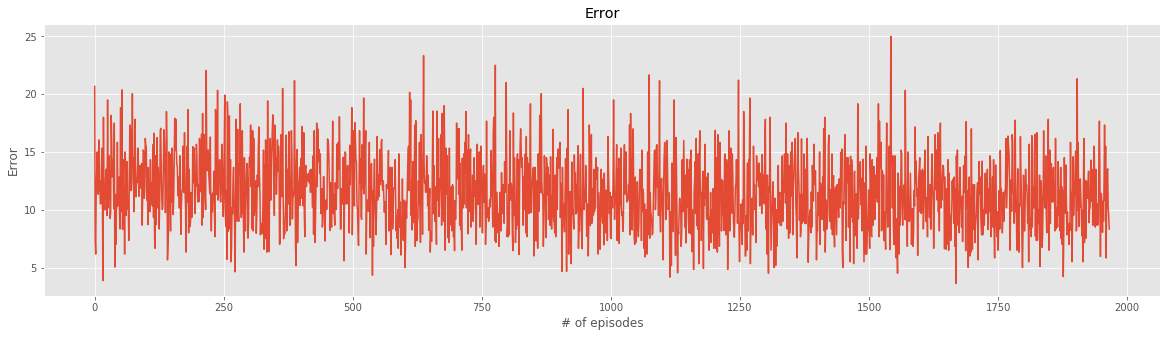

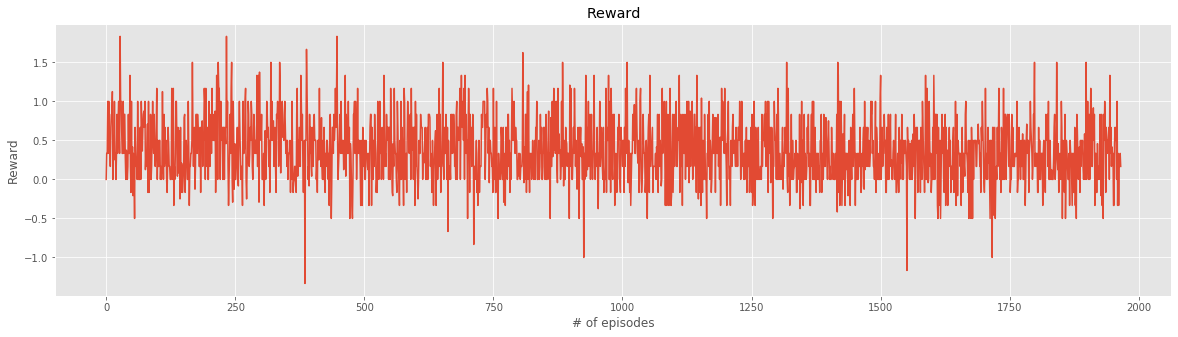

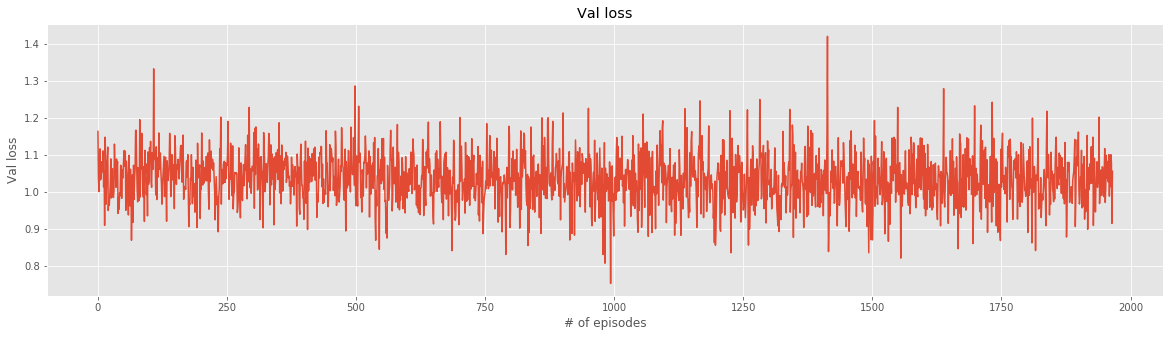

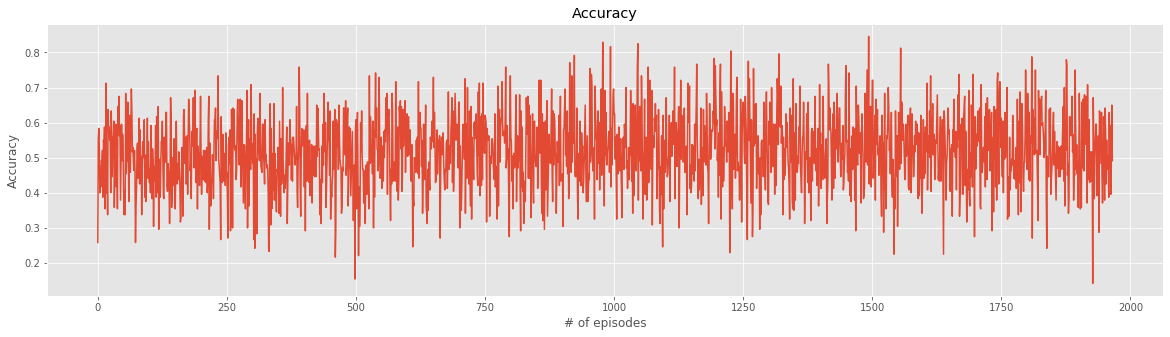

In [21]:
# the regular graphs
width = 20
height = 5

plt.figure(figsize=(width,height))
plt.plot(error_list_agg)
plt.title('Error')
plt.xlabel('# of episodes')
plt.ylabel('Error')
plt.show()

plt.figure(figsize=(width,height))
plt.plot(reward_list_agg)
plt.title('Reward')
plt.xlabel('# of episodes')
plt.ylabel('Reward')
plt.show()

plt.figure(figsize=(width,height))
plt.plot(val_loss_list_agg)
plt.title('Val loss')
plt.xlabel('# of episodes')
plt.ylabel('Val loss')
plt.show()

plt.figure(figsize=(width,height))
plt.plot(accuracy_list_agg)
plt.title('Accuracy')
plt.xlabel('# of episodes')
plt.ylabel('Accuracy')
plt.show()

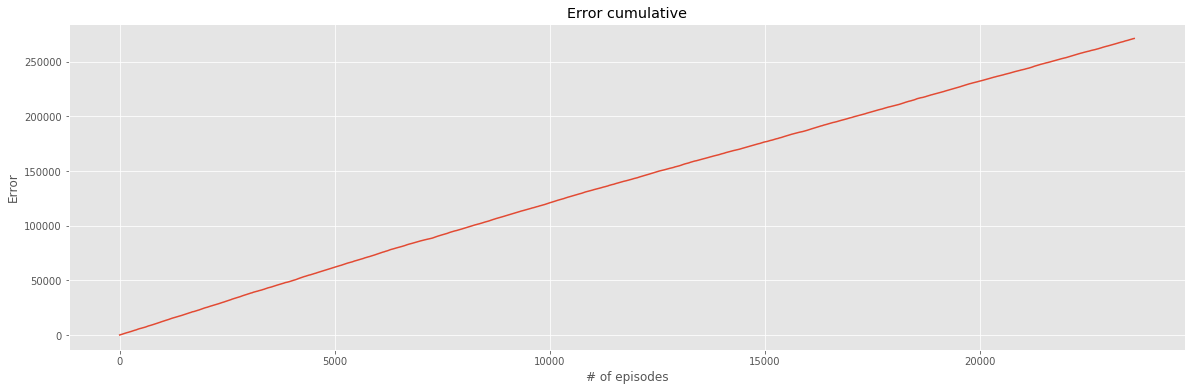

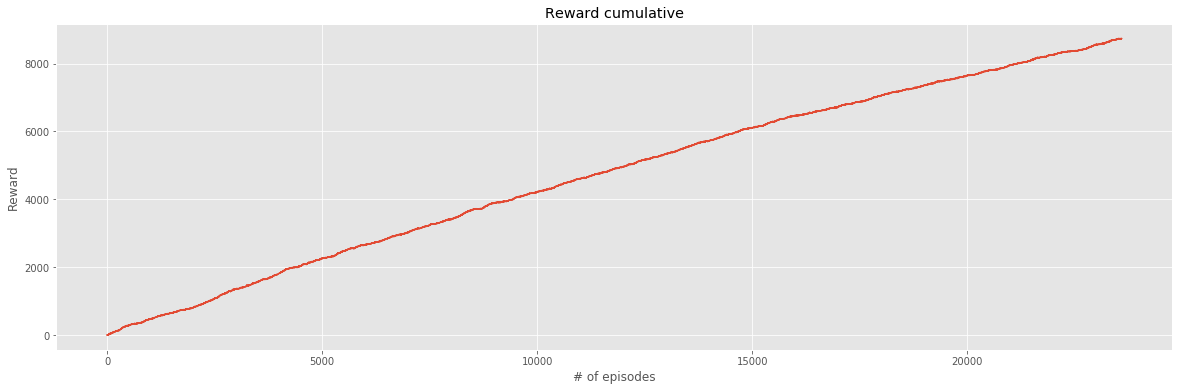

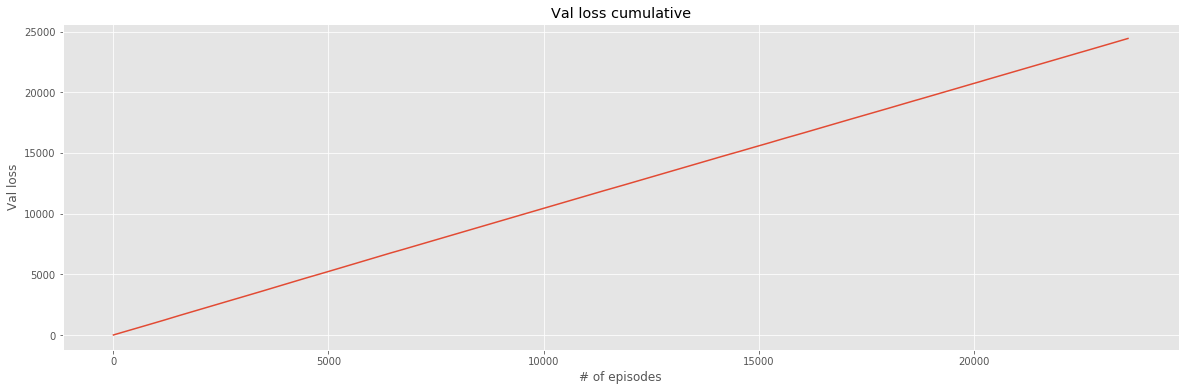

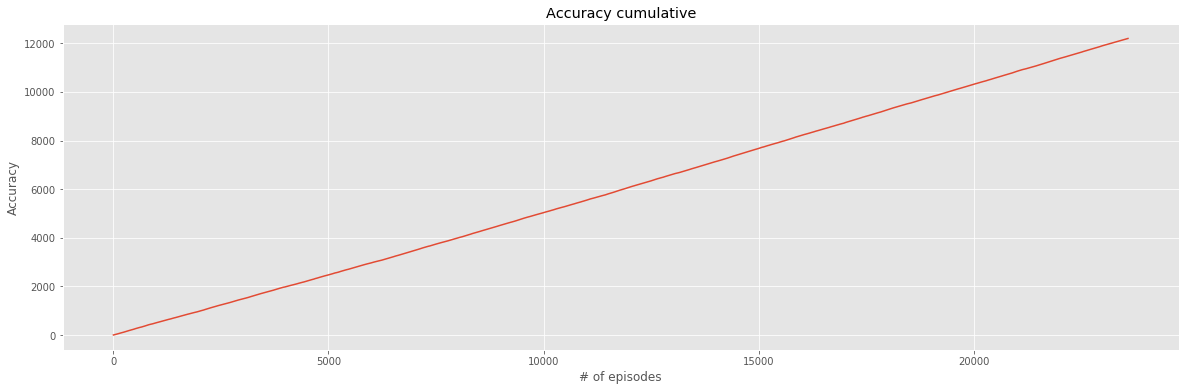

In [22]:
# the cumulative graphs
width = 20
height = 6

plt.figure(figsize=(width,height))
plt.plot(error_list_agg_cumulative)
plt.title('Error cumulative')
plt.xlabel('# of episodes')
plt.ylabel('Error')
plt.show()

plt.figure(figsize=(width,height))
plt.plot(reward_list_agg_cumulative)
plt.title('Reward cumulative')
plt.xlabel('# of episodes')
plt.ylabel('Reward')
plt.show()

plt.figure(figsize=(width,height))
plt.plot(val_loss_list_agg_cumulative)
plt.title('Val loss cumulative')
plt.xlabel('# of episodes')
plt.ylabel('Val loss')
plt.show()

plt.figure(figsize=(width,height))
plt.plot(accuracy_list_agg_cumulative)
plt.title('Accuracy cumulative')
plt.xlabel('# of episodes')
plt.ylabel('Accuracy')
plt.show()

<font style='font-weight:750;font-size:16px;text-decoration:underline;'>Models comparison</font>

In [28]:
#Check Q with test set
final_F = set()
final_F_ordered = []
final_available_F = set(range(1,x_test.shape[1]+1))

random_F = set()
random_F_ordered = []
random_available_F = set(range(1,x_test.shape[1]+1))

final_state=0
random_state=0

final_action=None
random_action=None

final_list=[]
random_list=[]

final_error_list = []
final_loss_list = []
final_accuracy_list = []

random_error_list = []
random_loss_list = []
random_accuracy_list = []


while len(final_available_F) > 0 and len(random_available_F) > 0:
    highest_value = np.max(Q[final_state,list(final_available_F)])
    final_action=np.intersect1d(np.argwhere(Q[final_state,:]==highest_value),list(final_available_F))[0]
    
    random_action=sample(random_available_F,1)[0]
    
    print('final state: {}; final action: {}'.format(final_state,final_action))
    final_available_F.remove(final_action)
    final_F_ordered.append(final_action)
    final_F.add(final_action)
    print('final_available_F:', final_available_F)
    print('final_F:', final_F)
    
    print('random state: {}; random action: {}'.format(random_state,random_action))
    random_available_F.remove(random_action)
    random_F_ordered.append(random_action)
    random_F.add(random_action)
    print('random_available_F:', random_available_F)
    print('random_F:', random_F)

    # choose only the F features to be in the train and val data sets
    # we need the F_minus_one becuse the real features are strating from zero and not form one
    final_F_minus_one = [feat - 1 for feat in final_F]
    random_F_minus_one = [feat - 1 for feat in random_F]
    
    X_train_final = x_train.iloc[:,list(final_F_minus_one)]
    X_train_random = x_train.iloc[:,list(random_F_minus_one)]
    
    X_test_final = x_test.iloc[:,list(final_F_minus_one)]
    X_test_random = x_test.iloc[:,list(random_F_minus_one)]
        
    X_train_arr_final, Y_train_arr_final = df_to_arr(X_train_final, y_train)
    X_train_arr_random, Y_train_arr_random = df_to_arr(X_train_random, y_train)
    
    X_test_arr_final, Y_test_arr_final = df_to_arr(X_test_final, y_test)
    X_test_arr_random, Y_test_arr_random = df_to_arr(X_test_random, y_test)
    
    final_run_model, final_run_history= run_model(X_train_final, X_train_arr_final, Y_train_arr_final, X_test_arr_final, Y_test_arr_final, 2,[13]*2, [0]*2, 'relu', 'RMSprop')
    final_prediction_matrix = final_run_model.predict(x=X_test_final, batch_size=32, verbose=0)
    final_prediction_result = np.argmax(final_prediction_matrix, axis=-1)
    final_error = get_error(y_test, final_prediction_result)
    final_error_list.append(final_error)
    final_loss_list.append(final_run_history.history['val_loss'][-1])
    final_accuracy_list.append(final_run_history.history['val_categorical_accuracy'][-1])
    
    random_run_model, random_run_history= run_model(X_train_random, X_train_arr_random, Y_train_arr_random, X_test_arr_random, Y_test_arr_random, 2,[13]*2, [0]*2, 'relu', 'RMSprop')
    random_prediction_matrix = random_run_model.predict(x=X_test_random, batch_size=32, verbose=0)
    random_prediction_result = np.argmax(random_prediction_matrix, axis=-1)
    random_error = get_error(y_test, random_prediction_result)
    random_error_list.append(random_error)
    random_loss_list.append(random_run_history.history['val_loss'][-1])
    random_accuracy_list.append(random_run_history.history['val_categorical_accuracy'][-1])
  
    final_error=0
    random_error=0
        
    final_state=final_action
    random_state=random_action


final state: 0; final action: 4
final_available_F: {1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13}
final_F: {4}
random state: 0; random action: 5
random_available_F: {1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13}
random_F: {5}
final state: 4; final action: 3
final_available_F: {1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13}
final_F: {3, 4}
random state: 5; random action: 9
random_available_F: {1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 13}
random_F: {9, 5}
final state: 3; final action: 2
final_available_F: {1, 5, 6, 7, 8, 9, 10, 11, 12, 13}
final_F: {2, 3, 4}
random state: 9; random action: 1
random_available_F: {2, 3, 4, 6, 7, 8, 10, 11, 12, 13}
random_F: {9, 5, 1}
final state: 2; final action: 1
final_available_F: {5, 6, 7, 8, 9, 10, 11, 12, 13}
final_F: {1, 2, 3, 4}
random state: 1; random action: 2
random_available_F: {3, 4, 6, 7, 8, 10, 11, 12, 13}
random_F: {9, 2, 5, 1}
final state: 1; final action: 9
final_available_F: {5, 6, 7, 8, 10, 11, 12, 13}
final_F: {1, 2, 3, 4, 9}
random state: 2; random action: 8
rando

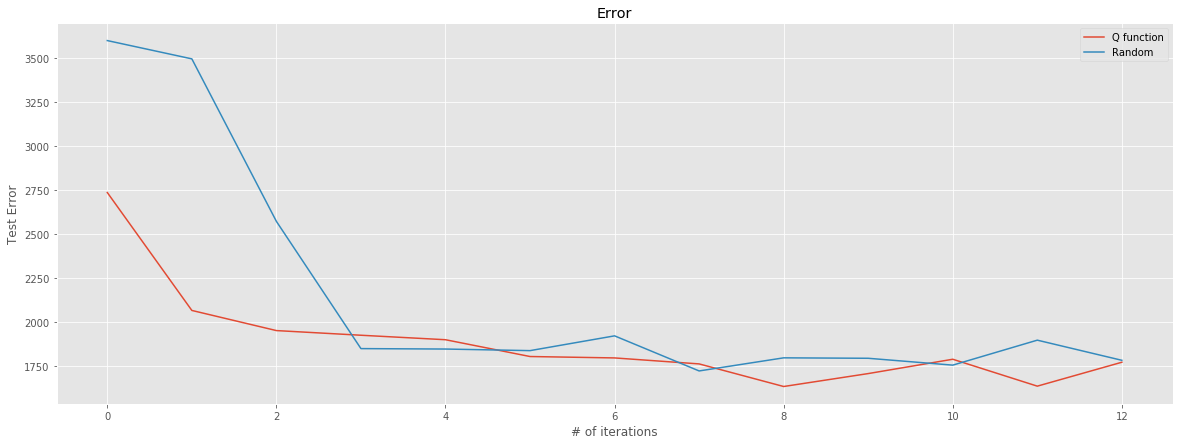

In [29]:
# Error
plt.figure(figsize=(20,7))
plt.plot(final_error_list, label="Q function")
plt.plot(random_error_list, label="Random")
plt.legend(loc="upper right")
plt.title('Error')
plt.xlabel('# of iterations')
plt.ylabel('Test Error')
plt.show()

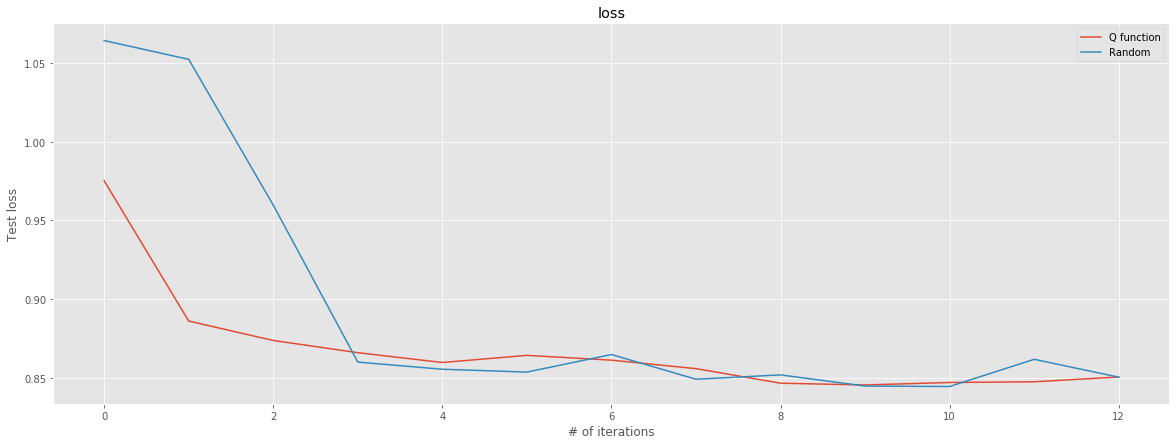

In [30]:
# Loss
plt.figure(figsize=(20,7))
plt.plot(final_loss_list, label="Q function")
plt.plot(random_loss_list, label="Random")
plt.legend(loc="upper right")
plt.title('loss')
plt.xlabel('# of iterations')
plt.ylabel('Test loss')
plt.show()

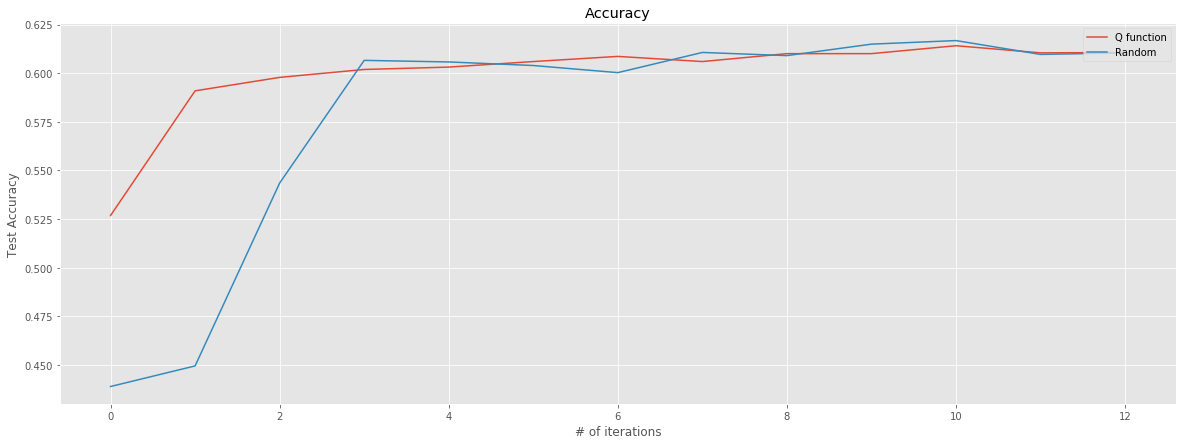

In [31]:
# Loss
plt.figure(figsize=(20,7))
plt.plot(final_accuracy_list, label="Q function")
plt.plot(random_accuracy_list, label="Random")
plt.legend(loc="upper right")
plt.title('Accuracy')
plt.xlabel('# of iterations')
plt.ylabel('Test Accuracy')
plt.show()

In [32]:
print('The order of the feature selection by Q is:\n',final_F_ordered)
print('\nThe order of the feature selection by random is:\n',random_F_ordered)

The order of the feature selection by Q is:
 [4, 3, 2, 1, 9, 10, 13, 5, 12, 6, 11, 7, 8]

The order of the feature selection by random is:
 [5, 9, 1, 2, 8, 12, 11, 3, 6, 4, 13, 7, 10]


In [57]:
# run model with the top three features by Q
top_three_features = [0,1,3]
X_train_top_three = x_train.iloc[:,top_three_features]
X_train_top_three_arr, Y_train_arr = df_to_arr(X_train_top_three, y_train)

X_test_top_three = x_test.iloc[:,top_three_features]
X_test_top_three_arr, Y_test_arr = df_to_arr(X_test_top_three, y_test)

top_three_run_model, top_three_run_history= run_model(X_train_top_three, X_train_top_three_arr, Y_train_arr, X_test_top_three_arr, Y_test_arr, 2,[13]*2, [0]*2, 'relu', 'RMSprop')
top_three_prediction_matrix = top_three_run_model.predict(x=X_test_top_three, batch_size=32, verbose=0)
top_three_prediction_result = np.argmax(top_three_prediction_matrix, axis=-1)
top_three_error = get_error(y_test, top_three_prediction_result)
top_three_loss = top_three_run_history.history['val_loss']
top_three_accuracy = top_three_run_history.history['val_categorical_accuracy']


In [58]:
# run model with random three features
random_three_features = sample(range(12),3)
X_train_random_three = x_train.iloc[:,random_three_features]
X_train_random_three_arr, Y_train_arr = df_to_arr(X_train_random_three, y_train)

X_test_random_three = x_test.iloc[:,random_three_features]
X_test_random_three_arr, Y_test_arr = df_to_arr(X_test_random_three, y_test)

random_three_run_model, random_three_run_history= run_model(X_train_random_three, X_train_random_three_arr, Y_train_arr, X_test_random_three_arr, Y_test_arr, 2,[13]*2, [0]*2, 'relu', 'RMSprop')
random_three_prediction_matrix = random_three_run_model.predict(x=X_test_random_three, batch_size=32, verbose=0)
random_three_prediction_result = np.argmax(random_three_prediction_matrix, axis=-1)
random_three_error = get_error(y_test, random_three_prediction_result)
random_three_loss = random_three_run_history.history['val_loss']
random_three_accuracy = random_three_run_history.history['val_categorical_accuracy']

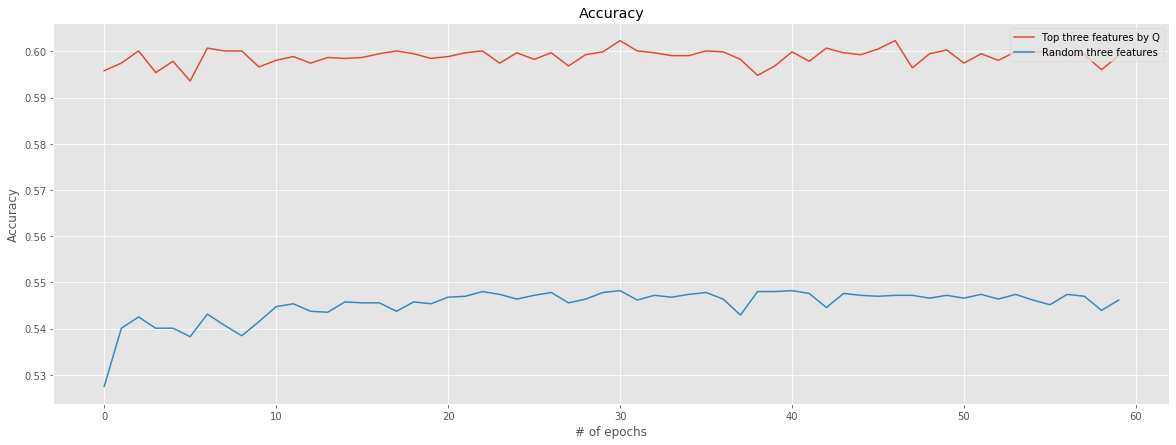

In [59]:
# Accuracy
plt.figure(figsize=(20,7))
plt.plot(top_three_accuracy, label="Top three features by Q")
plt.plot(random_three_accuracy, label="Random three features")
plt.legend(loc="upper right")
plt.title('Accuracy')
plt.xlabel('# of epochs')
plt.ylabel('Accuracy')
plt.show()

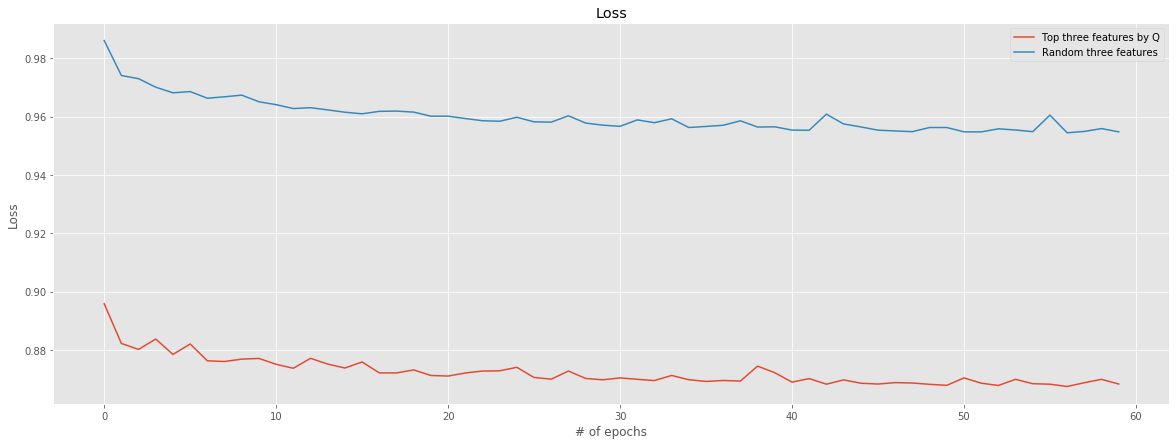

In [60]:
# Loss
plt.figure(figsize=(20,7))
plt.plot(top_three_loss, label="Top three features by Q")
plt.plot(random_three_loss, label="Random three features")
plt.legend(loc="upper right")
plt.title('Loss')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.show()